<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<h1>1. Libraries</h1>

In [1]:
# Data constructs:
import pandas as pd
import numpy as np
from scipy.sparse import hstack

# Preprosessing:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
import re

# Visuals:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Models:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier

# Metrics:
from sklearn.metrics import confusion_matrix,accuracy_score, log_loss, normalized_mutual_info_score

# Model parameter evaluation:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Extras:
import time
import warnings
warnings.filterwarnings("ignore")
# from imblearn.over_sampling import SMOTE
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
import math
from prettytable import PrettyTable

c:\users\byron\applications\pythonmaster\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<h1>2. Exploratory Data Analysis</h1>

<h2>2.1. Reading Data</h2>

In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>
    training/training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

In [3]:
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h2>2.2 Preprocessing of data</h2>

In [4]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [5]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")        

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 123.96639732000001 seconds


In [6]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [9]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [10]:
Y_true = result['Class'].values
result['Gene'] = result['Gene'].str.replace('\s+', '_')
result['Variation'] = result['Variation'].str.replace('\s+', '_')

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set - stratify </p>

In [11]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, Y_train, Y_test = train_test_split(result, Y_true, stratify=Y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.2)

In [12]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 2124
Number of data points in cross validation data: 532
Number of data points in test data: 665


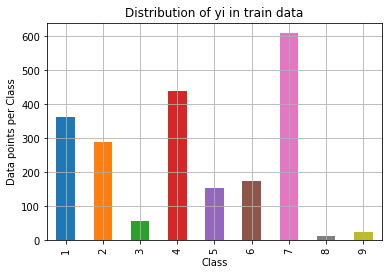

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


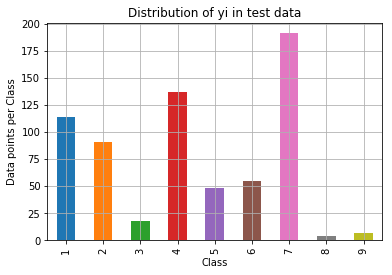

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


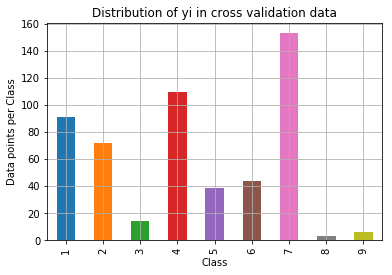

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [13]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = X_train['Class'].value_counts().sortlevel()
cv_class_distribution = X_cv['Class'].value_counts().sortlevel()
test_class_distribution = X_test['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/X_test.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/X_cv.shape[0]*100), 3), '%)')


<h2>2.3 One hot encodings</h2>

The below code does exactly the same that labelbinizer would have done. It uses binary BOW to construct a binary feature for each category of the categorical feature - gene & variation.

In [14]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer(binary = True)
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
columns = gene_vectorizer.get_feature_names()
train_gene_feature_onehotCoding = pd.DataFrame(data=train_gene_feature_onehotCoding.toarray(),columns=columns)
train_gene_feature_onehotCoding.index = X_train.index.values
cv_gene_feature_onehotCoding = gene_vectorizer.transform(X_cv['Gene'])
cv_gene_feature_onehotCoding = pd.DataFrame(data=cv_gene_feature_onehotCoding.toarray(),columns=columns)
cv_gene_feature_onehotCoding.index = X_cv.index.values
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
test_gene_feature_onehotCoding = pd.DataFrame(data=test_gene_feature_onehotCoding.toarray(),columns=columns)
test_gene_feature_onehotCoding.index = X_test.index.values

In [15]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer(binary = True)
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
columns = variation_vectorizer.get_feature_names()
train_variation_feature_onehotCoding = pd.DataFrame(data=train_variation_feature_onehotCoding.toarray(),columns=columns)
train_variation_feature_onehotCoding.index = X_train.index.values
cv_variation_feature_onehotCoding = variation_vectorizer.transform(X_cv['Variation'])
cv_variation_feature_onehotCoding = pd.DataFrame(data=cv_variation_feature_onehotCoding.toarray(),columns=columns)
cv_variation_feature_onehotCoding.index = X_cv.index.values
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
test_variation_feature_onehotCoding = pd.DataFrame(data=test_variation_feature_onehotCoding.toarray(),columns=columns)
test_variation_feature_onehotCoding.index = X_test.index.values

<h2>2.4 Response encodings</h2>

The functions calculate the likelyhood probability via response encoding P(Y=i|X=j)

In [16]:
def likelyhoods(numerator,denominator,alpha,k):
    return (numerator + alpha)/(denominator + k*alpha)

In [17]:
def response_encode(Data,feature):
    dic = dict()
    for i in Data.index.values:
        denominator = Data.loc[:,feature].value_counts()[Data.loc[i,feature]]
        cat = Data.loc[i,feature]
        label = Data.loc[i,'Class']
        query = feature+' '+'== @cat & Class == @label'
        numerator = Data.query(query).shape[0]
        dic[i] = likelyhoods(numerator,denominator,alpha=1,k=9)
    return dic   

In [18]:
#response-coding of the Gene feature
train_gene_feature_responseCoding = pd.DataFrame()
train_gene_feature_responseCoding['Gene_response_encoded'] = response_encode(Data=X_train,feature='Gene').values()
train_gene_feature_responseCoding.index = response_encode(Data=X_train,feature='Gene').keys()

cv_gene_feature_responseCoding = pd.DataFrame()
cv_gene_feature_responseCoding['Gene_response_encoded'] = response_encode(Data=X_cv,feature='Gene').values()
cv_gene_feature_responseCoding.index = response_encode(Data=X_cv,feature='Gene').keys()

test_gene_feature_responseCoding = pd.DataFrame()
test_gene_feature_responseCoding['Gene_response_encoded'] = response_encode(Data=X_test,feature='Gene').values()
test_gene_feature_responseCoding.index = response_encode(Data=X_test,feature='Gene').keys()

#response-coding of the Variation feature
train_variation_feature_responseCoding = pd.DataFrame()
train_variation_feature_responseCoding['Variation_response_encoded'] = response_encode(Data=X_train,feature='Variation').values()
train_variation_feature_responseCoding.index = response_encode(Data=X_train,feature='Variation').keys()

cv_variation_feature_responseCoding = pd.DataFrame()
cv_variation_feature_responseCoding['Variation_response_encoded'] = response_encode(Data=X_cv,feature='Variation').values()
cv_variation_feature_responseCoding.index = response_encode(Data=X_cv,feature='Variation').keys()

test_variation_feature_responseCoding = pd.DataFrame()
test_variation_feature_responseCoding['Variation_response_encoded'] = response_encode(Data=X_test,feature='Variation').values()
test_variation_feature_responseCoding.index = response_encode(Data=X_test,feature='Variation').keys()

<h2>2.5 Text vectorisation</h2>

<h3>2.5.1 Text vectorisation - BOW</h3>

The below calculates the word frequencies of the TEXT feature using BOW with uni and bi grams. I used a max of 5000 features since that is all I was able to successfully implement due to memory constraints

In [19]:
# Count vectoriser:
text_vectorizer = CountVectorizer(ngram_range=(1, 3), binary=False, max_features=5000)
train_text_feature_bow = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_bow = pd.DataFrame(data=train_text_feature_bow.toarray(),columns=train_text_features)
# train_text_feature_bow.index = X_train.index.values
cv_text_feature_bow = text_vectorizer.transform(X_cv['TEXT'])
# cv_text_feature_bow = pd.DataFrame(data=cv_text_feature_bow.toarray(),columns=train_text_features)
# cv_text_feature_bow.index = X_cv.index.values
test_text_feature_bow = text_vectorizer.transform(X_test['TEXT'])
# test_text_feature_bow = pd.DataFrame(data=test_text_feature_bow.toarray(),columns=train_text_features)
# test_text_feature_bow.index = X_test.index.values

The below while loops construct the train,cv and test dataframes. Due to large size it keeps concatenating 50 observations at every loop.

In [20]:
# construct bow train:
i = 0
bow = pd.DataFrame()
while i <= train_text_feature_bow.shape[0]:
    if i < train_text_feature_bow.shape[0]:
        frame = pd.DataFrame(data=train_text_feature_bow[i:i+50,:].toarray(),columns=train_text_features)
    elif i >= train_text_feature_tfidf.shape[0]: 
        frame = pd.DataFrame(data=train_text_feature_bow[i:,:].toarray(),columns=train_text_features)
#     frame.drop(labels=remove, axis=1, inplace=True)
    bow = pd.concat(objs=[bow,frame], axis=0)
    i += 50
train_text_feature_bow = bow
train_text_feature_bow.index = X_train.index.values

In [21]:
# construct bow CV:
i = 0
bow = pd.DataFrame()
while i <= cv_text_feature_bow.shape[0]:
    if i < cv_text_feature_bow.shape[0]:
        frame = pd.DataFrame(data=cv_text_feature_bow[i:i+50,:].toarray(),columns=train_text_features)
    elif i >= train_text_feature_tfidf.shape[0]: 
        frame = pd.DataFrame(data=cv_text_feature_bow[i:,:].toarray(),columns=train_text_features)
#     frame.drop(labels=remove, axis=1, inplace=True)
    bow = pd.concat(objs=[bow,frame], axis=0)
    i += 50
cv_text_feature_bow = bow
cv_text_feature_bow.index = X_cv.index.values

In [22]:
# construct bow test:
i = 0
bow = pd.DataFrame()
while i <= test_text_feature_bow.shape[0]:
    if i < test_text_feature_bow.shape[0]:
        frame = pd.DataFrame(data=test_text_feature_bow[i:i+50,:].toarray(),columns=train_text_features)
    elif i >= train_text_feature_tfidf.shape[0]: 
        frame = pd.DataFrame(data=test_text_feature_bow[i:,:].toarray(),columns=train_text_features)
#     frame.drop(labels=remove, axis=1, inplace=True)
    bow = pd.concat(objs=[bow,frame], axis=0)
    i += 50
test_text_feature_bow = bow
test_text_feature_bow.index = X_test.index.values

<h3>2.5.2 Text vectorisation - TF-IDF</h3>

The below code encodes the TEXT feature using weighted IDF values, it considers uni and bi grams.

In [23]:
# TF-IDF vectoriser:
text_vectorizer = TfidfVectorizer(ngram_range=(1, 3), binary=False, use_idf=True)
train_text_feature_tfidf = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

cv_text_feature_tfidf = text_vectorizer.transform(X_cv['TEXT'])
test_text_feature_tfidf = text_vectorizer.transform(X_test['TEXT'])

Below code constructs a dataframe of the top 1000 features based on the highest IDF values

In [24]:
dic = dict()
for i in range(np.sort(text_vectorizer.idf_)[-1000:].shape[0]):
    dic[train_text_features[i]] = text_vectorizer.idf_[i]

In [25]:
# build up the list of features to remove
remove = list()
for i in train_text_features:
    if i not in dic.keys():
        remove.append(i)

The while loops below concatenates frames 50 observations at a time after every loop. It drops the labels that should be removed and only retains the top 1000 IDF ranked values

In [26]:
# construct top 1000 idf train:
i = 0
tfidf = pd.DataFrame()
while i <= train_text_feature_tfidf.shape[0]:
    if i < train_text_feature_tfidf.shape[0]:
        frame = pd.DataFrame(data=train_text_feature_tfidf[i:i+50,:].toarray(),columns=train_text_features)
    elif i >= train_text_feature_tfidf.shape[0]: 
        frame = pd.DataFrame(data=train_text_feature_tfidf[i:,:].toarray(),columns=train_text_features)
    frame.drop(labels=remove, axis=1, inplace=True) #drop all columns that has to be removed, except the 1000 top ones
    tfidf = pd.concat(objs=[tfidf,frame], axis=0)
    i += 50
train_text_feature_tfidf = tfidf
train_text_feature_tfidf.index = X_train.index.values

In [27]:
# construct top 1000 idf cv:
i = 0
tfidf = pd.DataFrame()
while i <= cv_text_feature_tfidf.shape[0]:
    if i < cv_text_feature_tfidf.shape[0]:
        frame = pd.DataFrame(data=cv_text_feature_tfidf[i:i+50,:].toarray(),columns=train_text_features)
    elif i >= cv_text_feature_tfidf.shape[0]: 
        frame = pd.DataFrame(data=cv_text_feature_tfidf[i:,:].toarray(),columns=train_text_features)
    frame.drop(labels=remove, axis=1, inplace=True)
    tfidf = pd.concat(objs=[tfidf,frame], axis=0)
    i += 50
cv_text_feature_tfidf = tfidf
cv_text_feature_tfidf.index = X_cv.index.values

In [28]:
# construct top 1000 idf test:
i = 0
tfidf = pd.DataFrame()
while i <= test_text_feature_tfidf.shape[0]:
    if i < test_text_feature_tfidf.shape[0]:
        frame = pd.DataFrame(data=test_text_feature_tfidf[i:i+50,:].toarray(),columns=train_text_features)
    elif i >= test_text_feature_tfidf.shape[0]: 
        frame = pd.DataFrame(data=test_text_feature_tfidf[i:,:].toarray(),columns=train_text_features)
    frame.drop(labels=remove, axis=1, inplace=True)
    tfidf = pd.concat(objs=[tfidf,frame], axis=0)
    i += 50
test_text_feature_tfidf = tfidf
test_text_feature_tfidf.index = X_test.index.values

<h2>2.6 Combine all transformations</h2>

The below code makes use of the merge function to bring the various transformations together. Which will now be used in the various models.

In [29]:
# Combine train vectorised features - 1 hot encoded gene and variation + bow text:
D_train_onehot_bow = np.array(pd.merge(pd.merge(train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,how='inner',left_index=True,right_index=True),
                   train_text_feature_bow,how='inner',left_index=True,right_index=True))
# Combine cv vectorised features - 1 hot encoded gene and variation + bow text:
D_cv_onehot_bow = np.array(pd.merge(pd.merge(cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,how='inner',left_index=True,right_index=True),
                   cv_text_feature_bow,how='inner',left_index=True,right_index=True))
# Combine test vectorised features - 1 hot encoded gene and variation + bow text:
D_test_onehot_bow = np.array(pd.merge(pd.merge(test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,how='inner',left_index=True,right_index=True),
                   test_text_feature_bow,how='inner',left_index=True,right_index=True))


# Combine train vectorised features - 1 hot encoded gene and variation + tfidf text:
D_train_onehot_tfidf = np.array(pd.merge(pd.merge(train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,how='inner',left_index=True,right_index=True),
                   train_text_feature_tfidf,how='inner',left_index=True,right_index=True))
# Combine cv vectorised features - 1 hot encoded gene and variation + tfidf text:
D_cv_onehot_tfidf = np.array(pd.merge(pd.merge(cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,how='inner',left_index=True,right_index=True),
                   cv_text_feature_tfidf,how='inner',left_index=True,right_index=True))
# Combine test vectorised features - 1 hot encoded gene and variation + tfidf text:
D_test_onehot_tfidf = np.array(pd.merge(pd.merge(test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,how='inner',left_index=True,right_index=True),
                   test_text_feature_tfidf,how='inner',left_index=True,right_index=True))


# Combine train vectorised features - response encoded gene and variation + bow text:
D_train_response_bow = np.array(pd.merge(pd.merge(train_gene_feature_responseCoding,train_variation_feature_responseCoding,how='inner',left_index=True,right_index=True),
                   train_text_feature_bow,how='inner',left_index=True,right_index=True))
# Combine cv vectorised features - response encoded gene and variation + bow text:
D_cv_response_bow = np.array(pd.merge(pd.merge(cv_gene_feature_responseCoding,cv_variation_feature_responseCoding,how='inner',left_index=True,right_index=True),
                   cv_text_feature_bow,how='inner',left_index=True,right_index=True))
# Combine test vectorised features - response encoded gene and variation + bow text:
D_test_response_bow = np.array(pd.merge(pd.merge(test_gene_feature_responseCoding,test_variation_feature_responseCoding,how='inner',left_index=True,right_index=True),
                   test_text_feature_bow,how='inner',left_index=True,right_index=True))


# Combine train vectorised features - response encoded gene and variation + tfidf text:
D_train_response_tfidf = np.array(pd.merge(pd.merge(train_gene_feature_responseCoding,train_variation_feature_responseCoding,how='inner',left_index=True,right_index=True),
                   train_text_feature_tfidf,how='inner',left_index=True,right_index=True))
# Combine cv vectorised features - response encoded gene and variation + tfidf text:
D_cv_response_tfidf = np.array(pd.merge(pd.merge(cv_gene_feature_responseCoding,cv_variation_feature_responseCoding,how='inner',left_index=True,right_index=True),
                   cv_text_feature_tfidf,how='inner',left_index=True,right_index=True))
# Combine test vectorised features - response encoded gene and variation + tfidf text:
D_test_response_tfidf = np.array(pd.merge(pd.merge(test_gene_feature_responseCoding,test_variation_feature_responseCoding,how='inner',left_index=True,right_index=True),
                   test_text_feature_tfidf,how='inner',left_index=True,right_index=True))

<h1>3. Evaluation Metrics</h1>

- Log Loss
- Confusion matrix

In [30]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(actual_y, predicted_y):
    
    C = confusion_matrix(actual_y, predicted_y)   
    
    total_predictions_per_class = C.sum(axis=0) #column sum
    total_actuals_per_class = C.sum(axis=1) #row sum
    
    Precision_matrix = C/total_predictions_per_class
    Recall_matrix = np.transpose(np.transpose(C)/total_actuals_per_class)
    
#     A =(((C.T)/(C.sum(axis=1))).T)
#     B =(C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(Precision_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(Recall_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

<h1>4. Models</h1>

<h2>4.1 Random (Baseline) model</h2>

Log loss on Training Data using Random Model 2.5059464626402557
Log loss on CV Data using Random Model 2.5335345812474115
Log loss on Test Data using Random Model 2.4913679820060715
Number of missclassified points:  89.62 %
-------------------- Confusion matrix --------------------


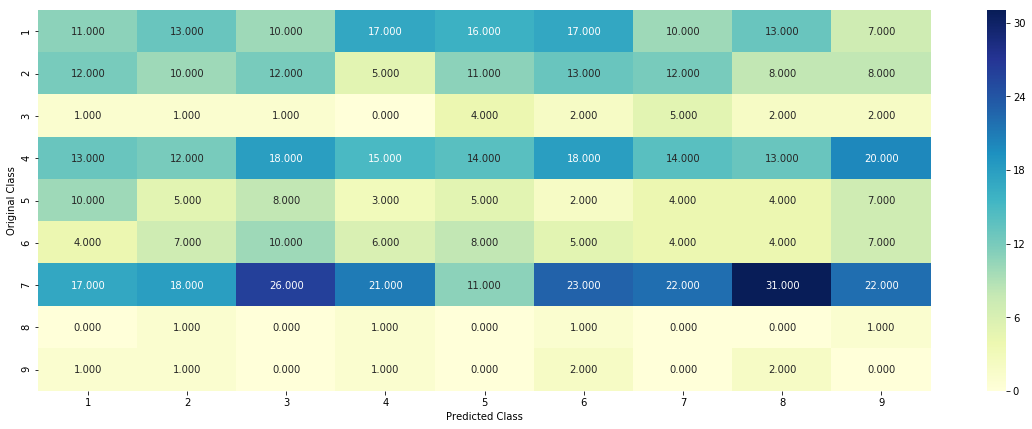

-------------------- Precision matrix (Columm Sum=1) --------------------


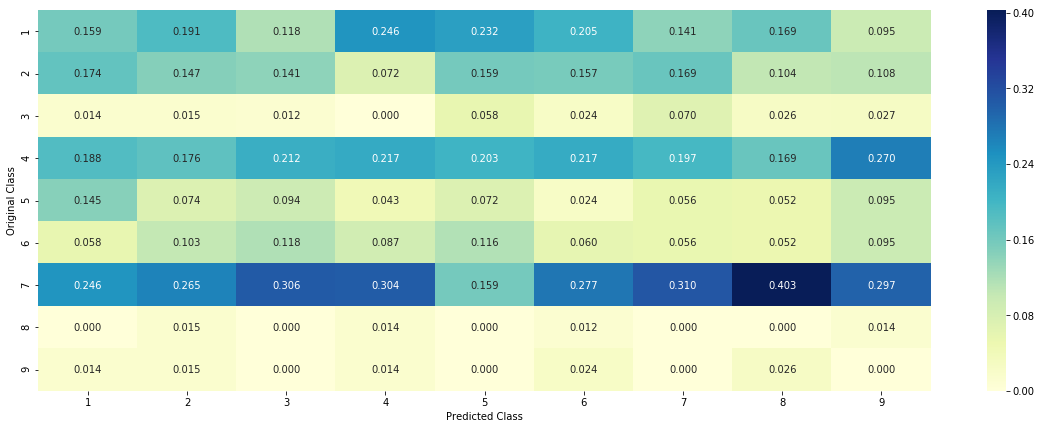

-------------------- Recall matrix (Row sum=1) --------------------


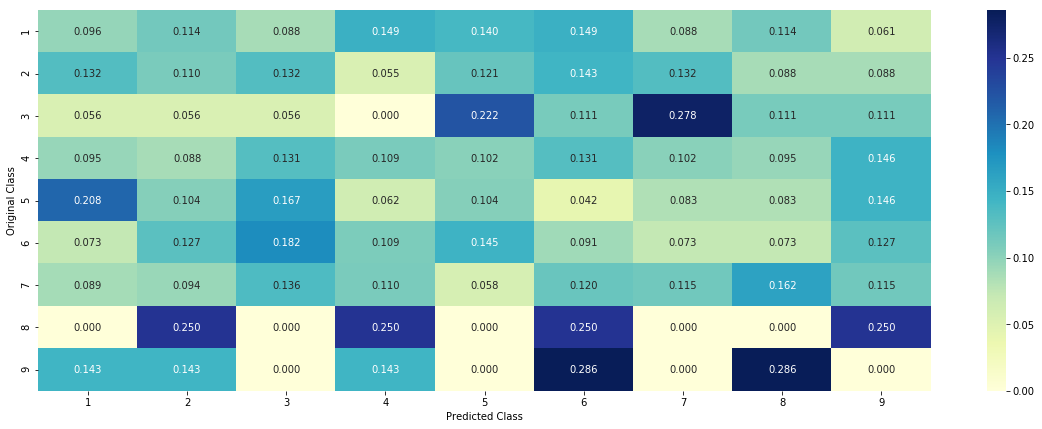

In [31]:
# The random models does not see any data, it basically simulates random probabilities for each observation:
obs_train = X_train.shape[0]
obs_cv = X_cv.shape[0]
obs_test = X_test.shape[0]

# Random model on training data:
gen_prob = np.random.rand(obs_train,9)
for i in range(gen_prob.shape[0]):
    gen_prob[i] =  gen_prob[i]*1/gen_prob.sum(axis=1)[i]
print("Log loss on Training Data using Random Model",log_loss(Y_train,gen_prob, eps=1e-15))

# Random model on CV data:
gen_prob = np.random.rand(obs_cv,9)
for i in range(gen_prob.shape[0]):
    gen_prob[i] =  gen_prob[i]*1/gen_prob.sum(axis=1)[i]
print("Log loss on CV Data using Random Model",log_loss(Y_cv,gen_prob, eps=1e-15))

# Random model on test data:
gen_prob = np.random.rand(obs_test,9)
for i in range(gen_prob.shape[0]):
    gen_prob[i] =  gen_prob[i]*1/gen_prob.sum(axis=1)[i]
print("Log loss on Test Data using Random Model",log_loss(Y_test,gen_prob, eps=1e-15))

# Miss classification rate on test data:
predicted_y = np.argmax(gen_prob, axis=1) + 1
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_y)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_y)

<h2>4.2 Naive Bayes model</h2>

for alpha = 1e-05
Log Loss : 1.413490785521591
for alpha = 0.0001
Log Loss : 1.4103978530909496
for alpha = 0.001
Log Loss : 1.4128509104676936
for alpha = 0.1
Log Loss : 1.4069249024528687
for alpha = 1
Log Loss : 1.4069076386670798
for alpha = 10
Log Loss : 1.404515400031922
for alpha = 100
Log Loss : 1.4413246239687054
for alpha = 1000
Log Loss : 1.7159680891013307


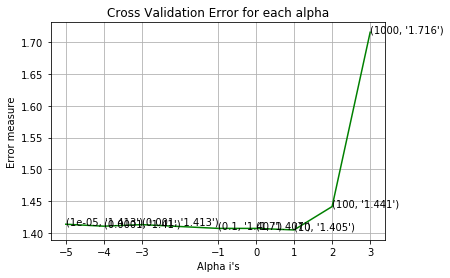

For values of best alpha =  10 The train log loss is: 1.2660271117381463
For values of best alpha =  10 The cross validation log loss is: 1.404515400031922
For values of best alpha =  10 The test log loss is: 1.3486774084594335
Number of missclassified points:  41.2 %
-------------------- Confusion matrix --------------------


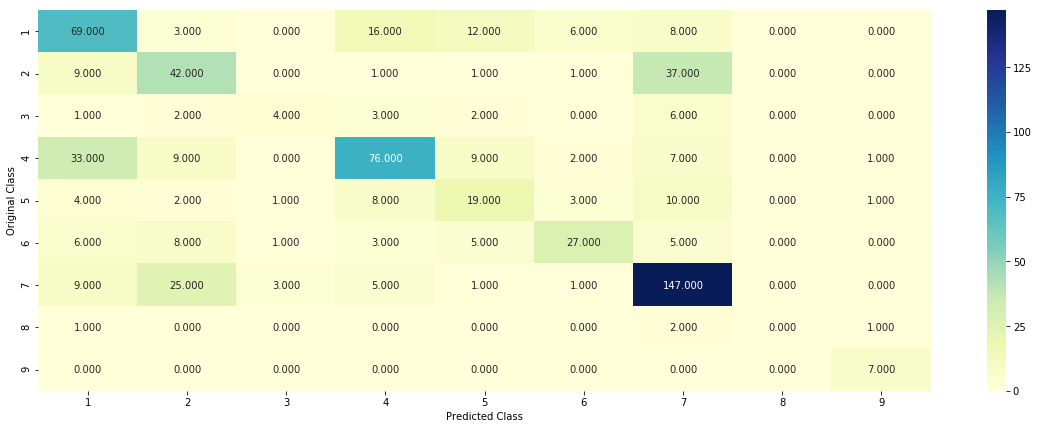

-------------------- Precision matrix (Columm Sum=1) --------------------


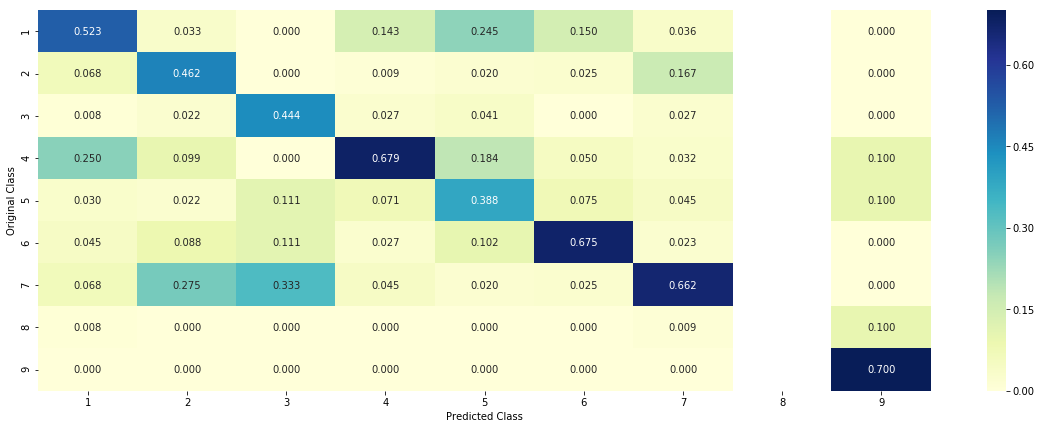

-------------------- Recall matrix (Row sum=1) --------------------


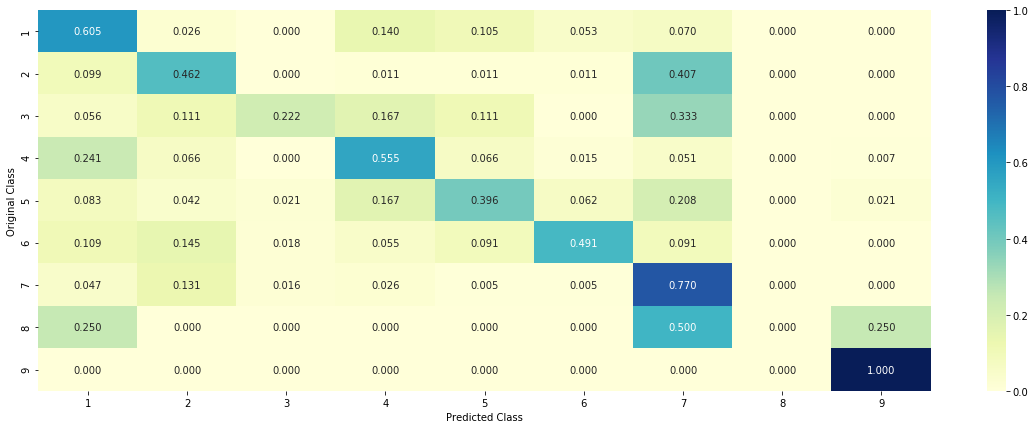

In [32]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(D_train_onehot_bow, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_onehot_bow, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(D_train_onehot_bow, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_bow, Y_train)


predict_y = sig_clf.predict_proba(D_train_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h2>4.3 KNN Classification</h2>

<h3>4.3.1 KNN Classification - response encoded (gene,variation) and BOW text</h3>

for alpha = 5
Log Loss : 1.2608964003711414
for alpha = 11
Log Loss : 1.3098196280479815
for alpha = 15
Log Loss : 1.357917142134213
for alpha = 21
Log Loss : 1.4081356529039337
for alpha = 31
Log Loss : 1.4448219192115113
for alpha = 41
Log Loss : 1.4677126332689783
for alpha = 51
Log Loss : 1.4772786454965898
for alpha = 99
Log Loss : 1.5064629759666524


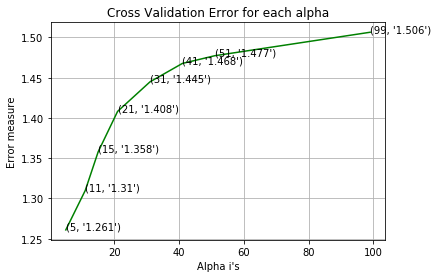

For values of best alpha =  5 The train log loss is: 0.9067579992675326
For values of best alpha =  5 The cross validation log loss is: 1.2608964003711414
For values of best alpha =  5 The test log loss is: 1.2114471520748322
Number of missclassified points:  40.9 %
-------------------- Confusion matrix --------------------


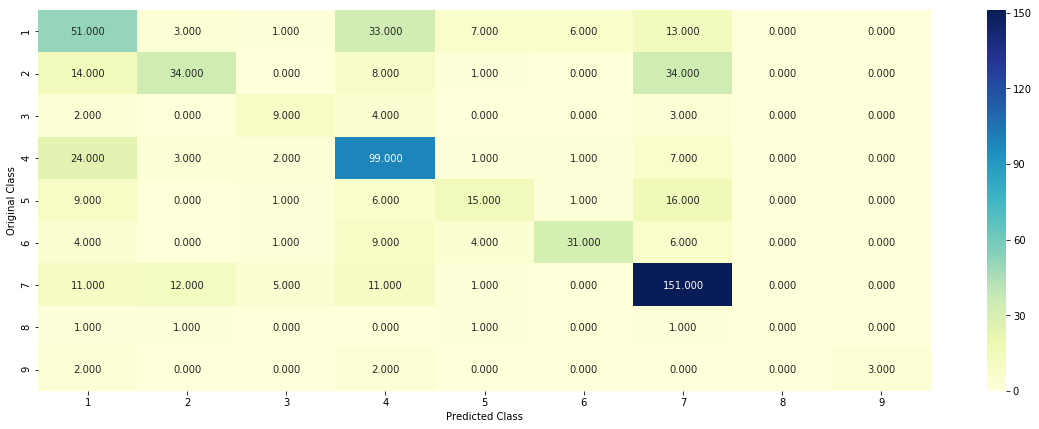

-------------------- Precision matrix (Columm Sum=1) --------------------


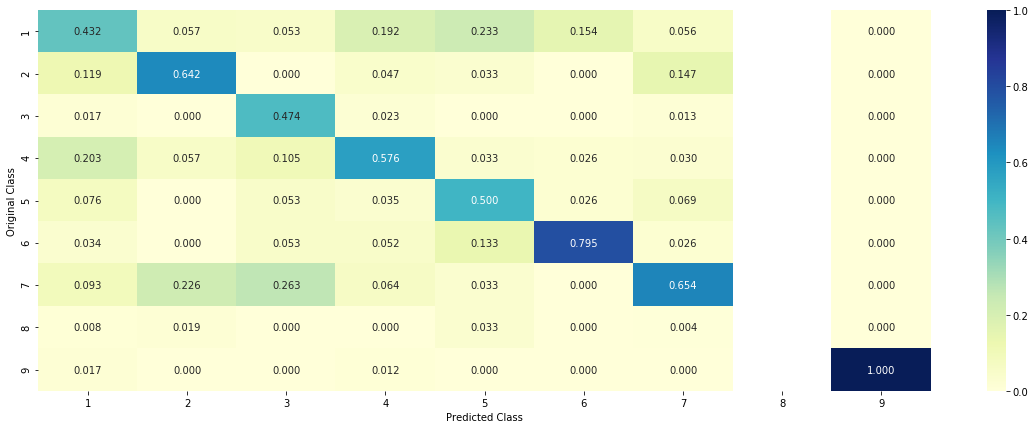

-------------------- Recall matrix (Row sum=1) --------------------


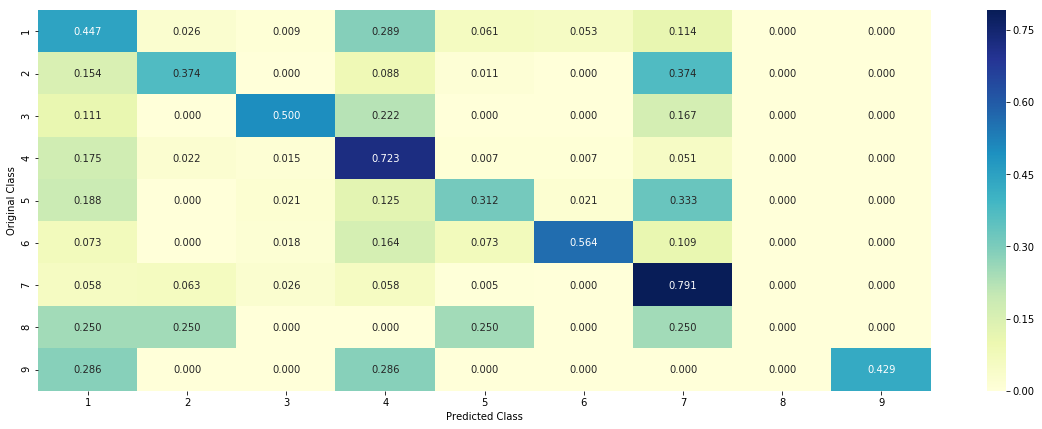

In [33]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(D_train_response_bow, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_response_bow, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_response_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(D_train_response_bow, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_response_bow, Y_train)

predict_y = sig_clf.predict_proba(D_train_response_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_response_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_response_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_response_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.3.2 KNN Classification - response encoded (gene,variation) and TFIDF text</h3>

for alpha = 5
Log Loss : 2.0438281309139823
for alpha = 11
Log Loss : 2.0001148200489864
for alpha = 15
Log Loss : 2.0265714775363906
for alpha = 21
Log Loss : 2.0272785538489866
for alpha = 31
Log Loss : 2.0035006305133285
for alpha = 41
Log Loss : 2.003703881420051
for alpha = 51
Log Loss : 2.0049619427601977
for alpha = 99
Log Loss : 1.9840037245817155


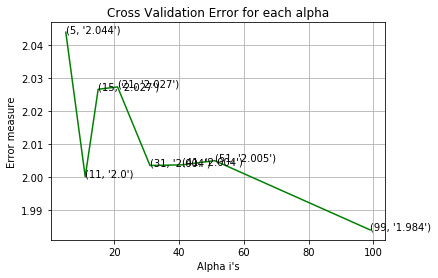

For values of best alpha =  99 The train log loss is: 1.3584182389456512
For values of best alpha =  99 The cross validation log loss is: 1.9840037245817155
For values of best alpha =  99 The test log loss is: 1.898481141890833
Number of missclassified points:  74.29 %
-------------------- Confusion matrix --------------------


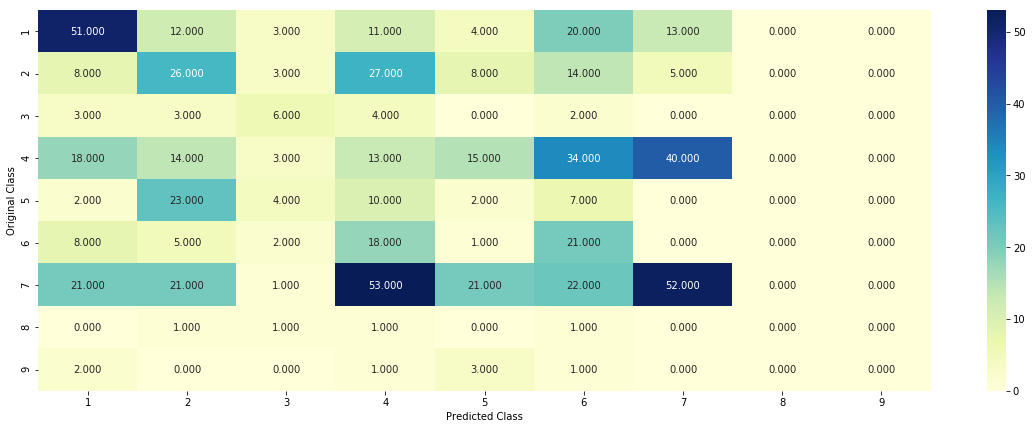

-------------------- Precision matrix (Columm Sum=1) --------------------


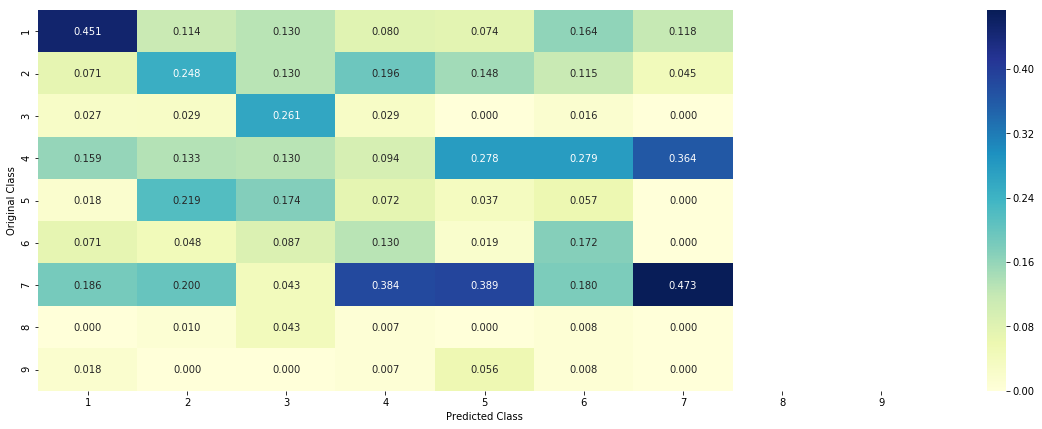

-------------------- Recall matrix (Row sum=1) --------------------


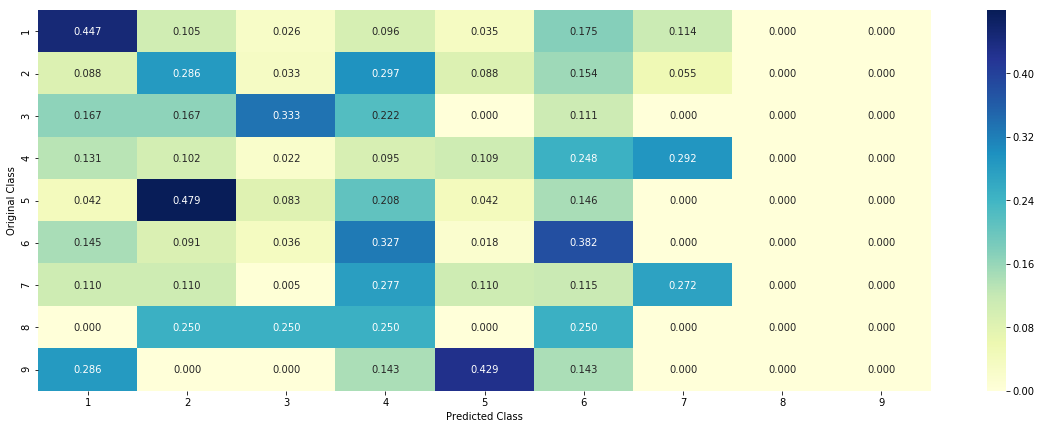

In [34]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(D_train_response_tfidf, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_response_tfidf, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_response_tfidf)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(D_train_response_tfidf, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_response_tfidf, Y_train)

predict_y = sig_clf.predict_proba(D_train_response_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_response_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_response_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_response_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h2>4.4 Logistic Regression</h2>

<h3>4.4.1 SGD(log loss) - on BOW (with class balance)</h3>

for alpha = 1e-06
Log Loss : 1.8304997567764278
for alpha = 1e-05
Log Loss : 1.8304997567764278
for alpha = 0.0001
Log Loss : 1.4381072717452115
for alpha = 0.001
Log Loss : 1.408452666777166
for alpha = 0.01
Log Loss : 1.416543716243525
for alpha = 0.1
Log Loss : 1.4169249801585373
for alpha = 1
Log Loss : 1.367163335407618
for alpha = 10
Log Loss : 1.2841008163686538
for alpha = 100
Log Loss : 1.3473592117268964


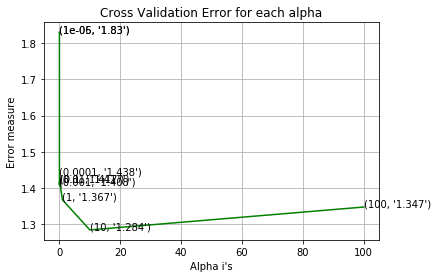

For values of best alpha =  10 The train log loss is: 1.0121951694752376
For values of best alpha =  10 The cross validation log loss is: 1.2841008163686538
For values of best alpha =  10 The test log loss is: 1.2406420061045127
Number of missclassified points:  41.05 %
-------------------- Confusion matrix --------------------


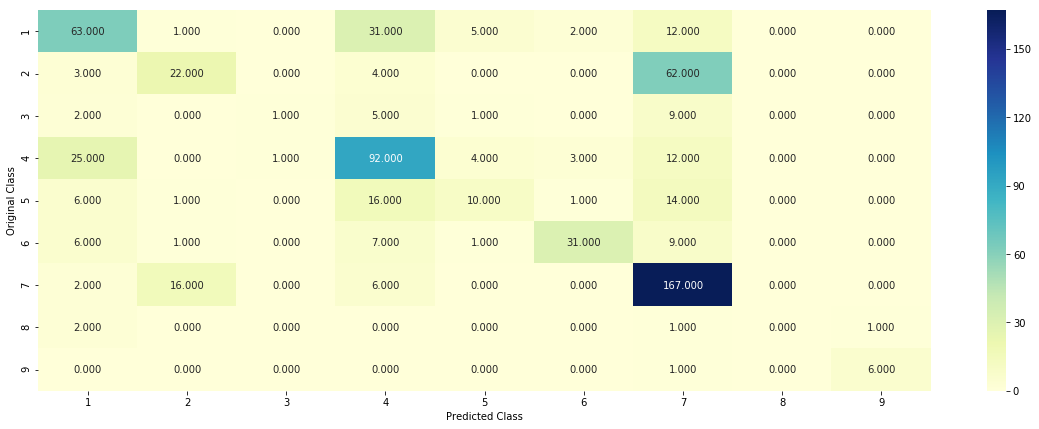

-------------------- Precision matrix (Columm Sum=1) --------------------


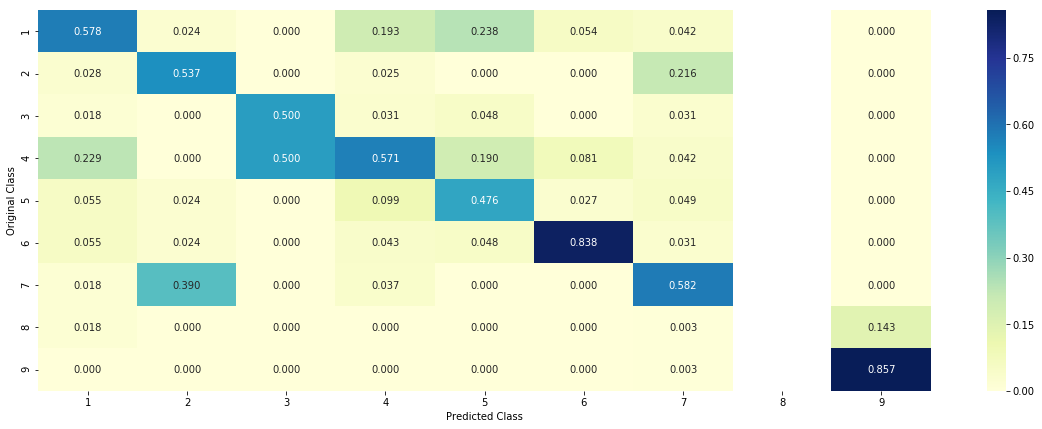

-------------------- Recall matrix (Row sum=1) --------------------


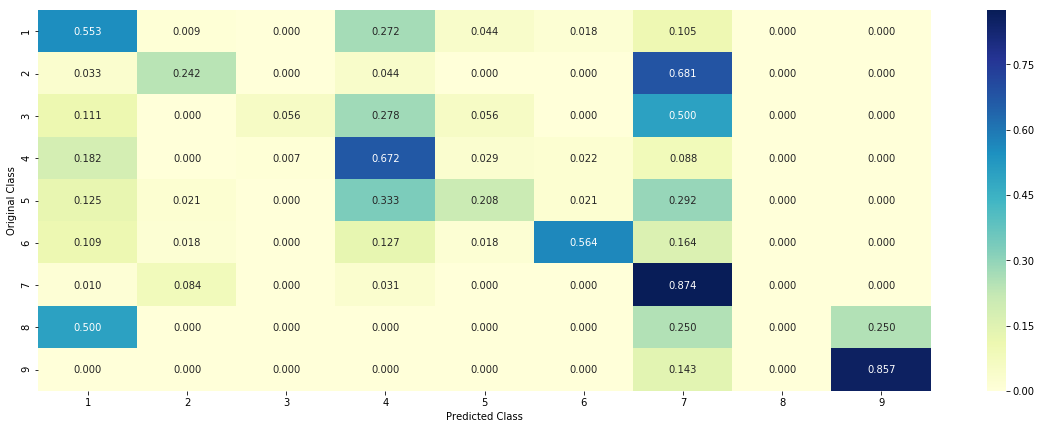

In [35]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(D_train_onehot_bow, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_onehot_bow, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(D_train_onehot_bow, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_bow, Y_train)

predict_y = sig_clf.predict_proba(D_train_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.4.2 SGD(log loss) - on TF-IDF (with class balance)</h3>

for alpha = 1e-06
Log Loss : 1.2142491014967172
for alpha = 1e-05
Log Loss : 1.1961770221496018
for alpha = 0.0001
Log Loss : 1.1452558305504326
for alpha = 0.001
Log Loss : 1.1748222037461304
for alpha = 0.01
Log Loss : 1.2830774265468563
for alpha = 0.1
Log Loss : 1.3230478159146175
for alpha = 1
Log Loss : 1.3238814603078992
for alpha = 10
Log Loss : 1.410371738644532
for alpha = 100
Log Loss : 1.433361462137884


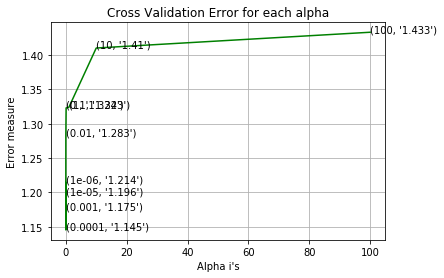

For values of best alpha =  0.0001 The train log loss is: 0.5215089684957567
For values of best alpha =  0.0001 The cross validation log loss is: 1.1452558305504326
For values of best alpha =  0.0001 The test log loss is: 1.1496063073294658
Number of missclassified points:  41.8 %
-------------------- Confusion matrix --------------------


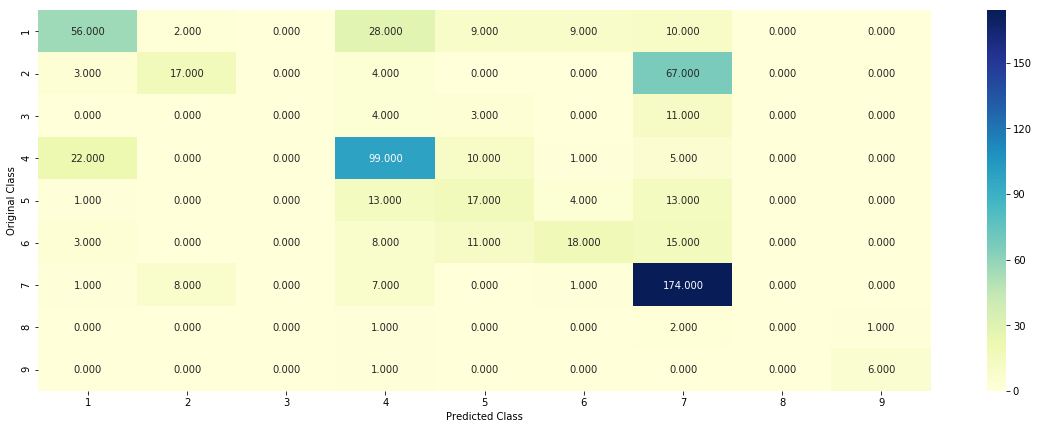

-------------------- Precision matrix (Columm Sum=1) --------------------


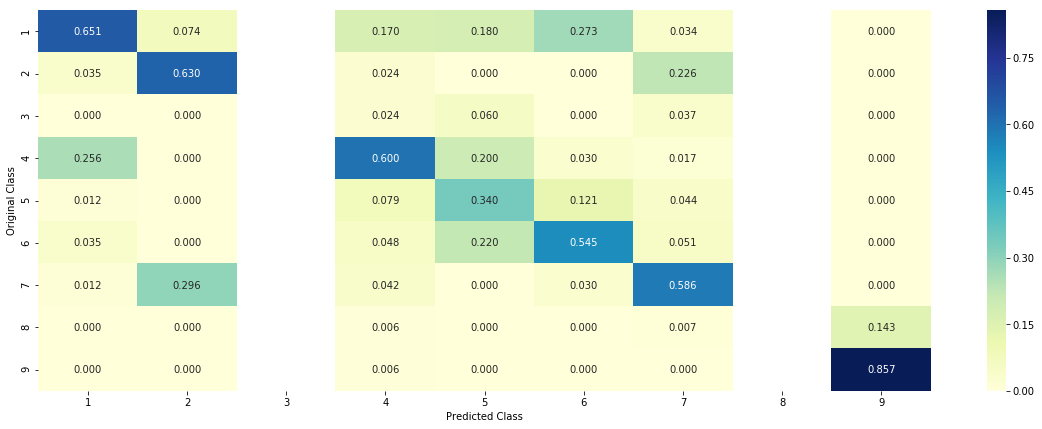

-------------------- Recall matrix (Row sum=1) --------------------


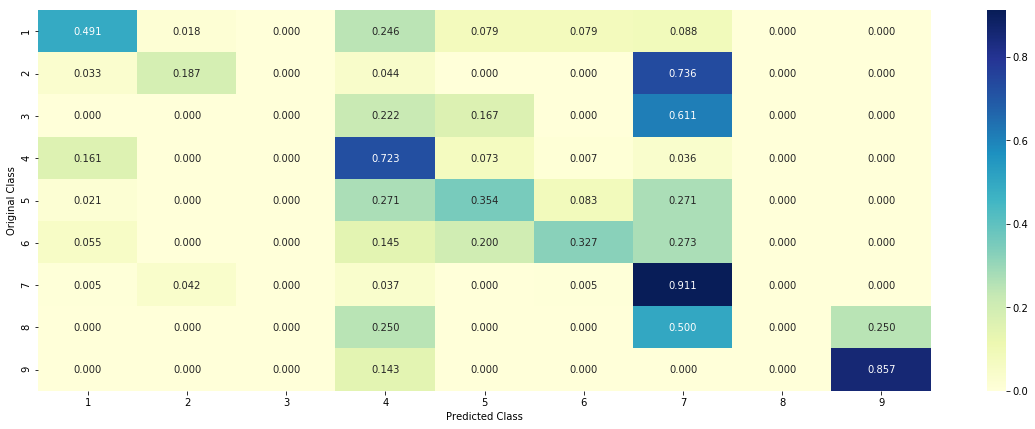

In [36]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(D_train_onehot_tfidf, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_onehot_tfidf, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_tfidf)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_tfidf, Y_train)

predict_y = sig_clf.predict_proba(D_train_onehot_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.4.3 Logistic Regression - on BOW (with class balance)</h3>

for alpha = 1e-06
Log Loss : 1.6028763773759074
for alpha = 1e-05
Log Loss : 1.3182182565500427
for alpha = 0.0001
Log Loss : 1.2076406273312412
for alpha = 0.001
Log Loss : 1.1824326023509464
for alpha = 0.01
Log Loss : 1.1893196653271336
for alpha = 0.1
Log Loss : 1.2044604749032521
for alpha = 1
Log Loss : 1.2199080763680041
for alpha = 10
Log Loss : 1.2305924557490544
for alpha = 100
Log Loss : 1.230804155651764


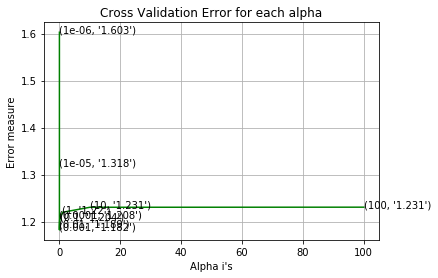

For values of best alpha =  0.001 The train log loss is: 0.9206258460640855
For values of best alpha =  0.001 The cross validation log loss is: 1.2308730577111038
For values of best alpha =  0.001 The test log loss is: 1.2842844144102035
Number of missclassified points:  41.35 %
-------------------- Confusion matrix --------------------


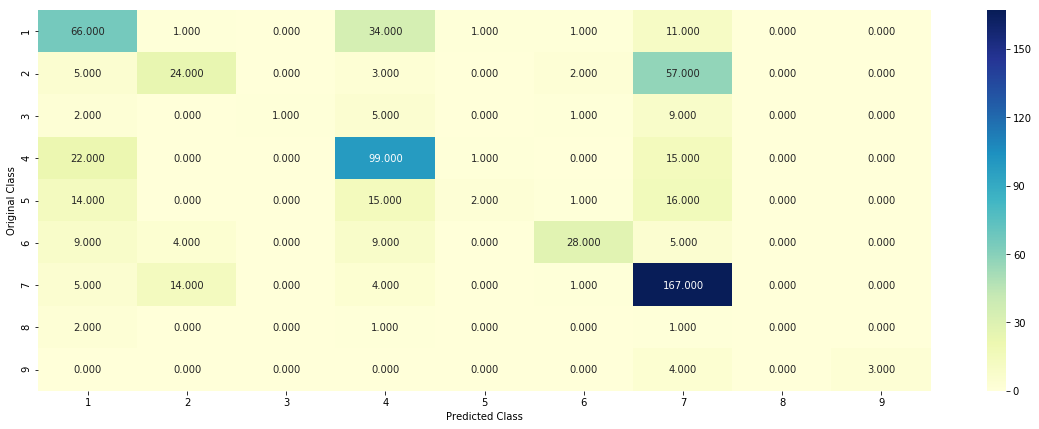

-------------------- Precision matrix (Columm Sum=1) --------------------


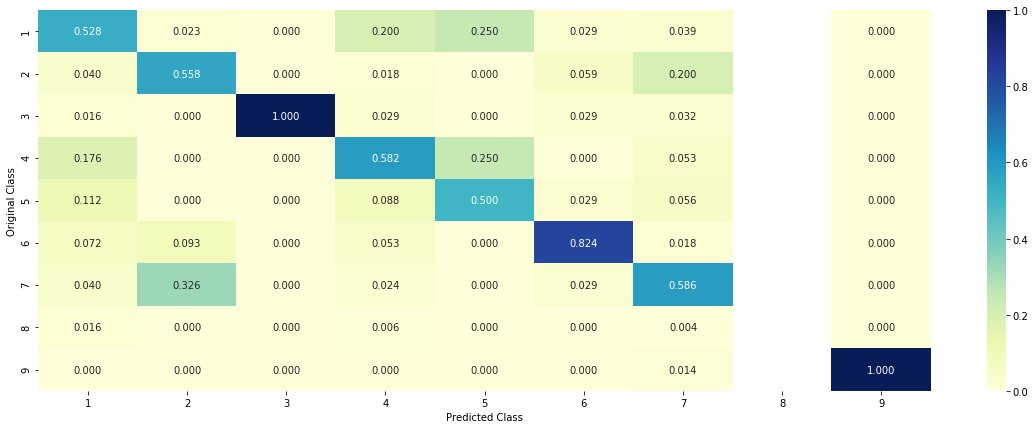

-------------------- Recall matrix (Row sum=1) --------------------


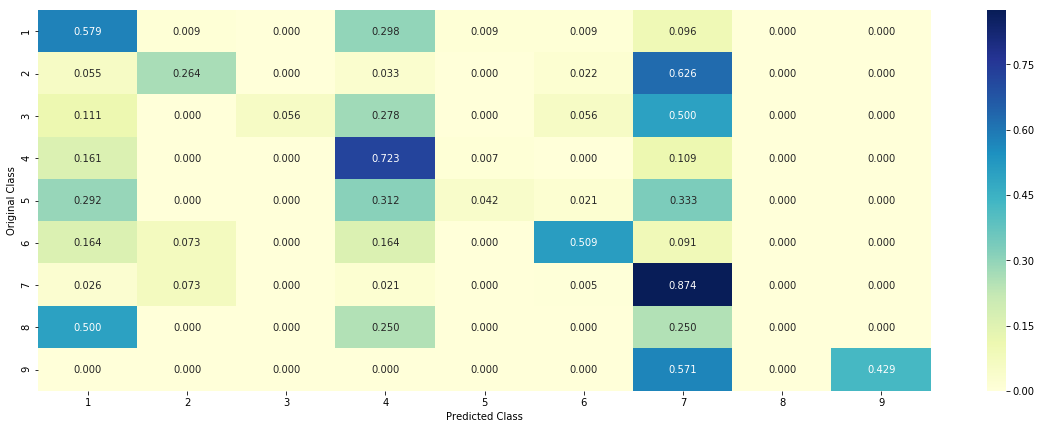

In [37]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', n_jobs=-1)
#     clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(D_train_onehot_bow, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_onehot_bow, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(class_weight='balanced', C=i, penalty='l2', n_jobs=-1)
# clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(D_train_onehot_bow, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_bow, Y_train)

predict_y = sig_clf.predict_proba(D_train_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h2>4.5 Support Vector Machines</h2>

<h3>4.5.1 SGD(hindge loss) - on BOW (with class balance)</h3>

for alpha = 1e-06
Log Loss : 1.8304997567764278
for alpha = 1e-05
Log Loss : 1.8304997567764278
for alpha = 0.0001
Log Loss : 1.4451628202295728
for alpha = 0.001
Log Loss : 1.3758529360139824
for alpha = 0.01
Log Loss : 1.3767167056870915
for alpha = 0.1
Log Loss : 1.3940121080415386
for alpha = 1
Log Loss : 1.3829958182492885
for alpha = 10
Log Loss : 1.3435995201274515
for alpha = 100
Log Loss : 1.3654935202378993


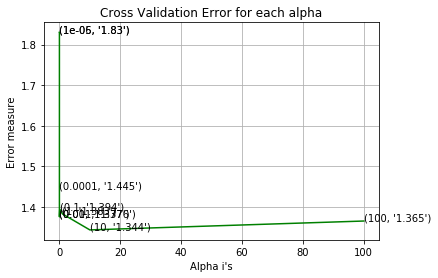

For values of best alpha =  10 The train log loss is: 1.0794568415661194
For values of best alpha =  10 The cross validation log loss is: 1.3435995201274515
For values of best alpha =  10 The test log loss is: 1.2897322167329706
Number of missclassified points:  42.26 %
-------------------- Confusion matrix --------------------


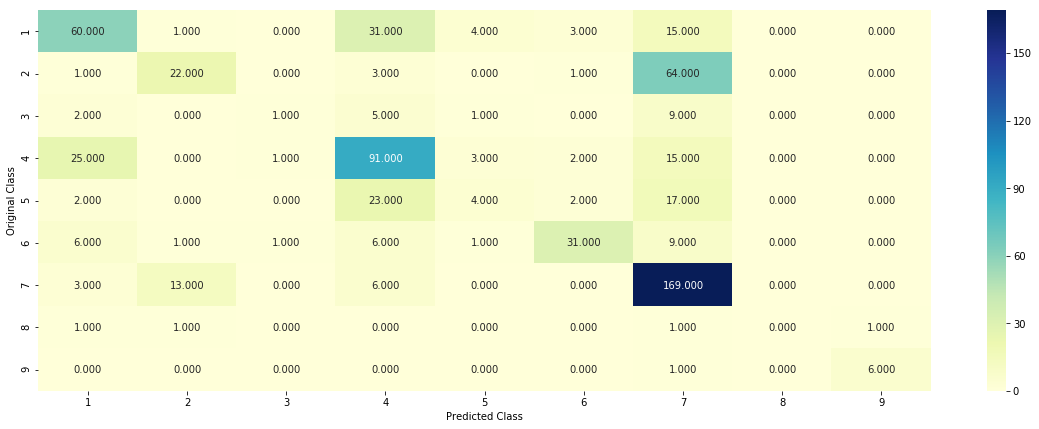

-------------------- Precision matrix (Columm Sum=1) --------------------


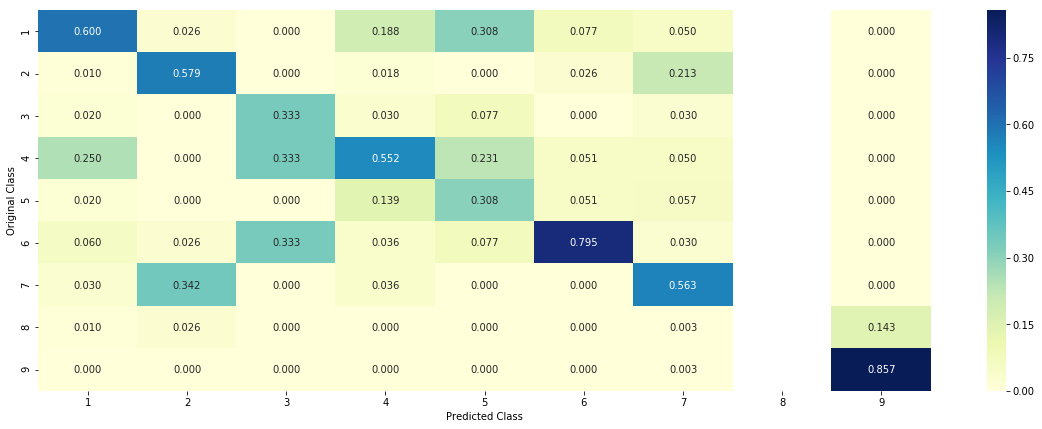

-------------------- Recall matrix (Row sum=1) --------------------


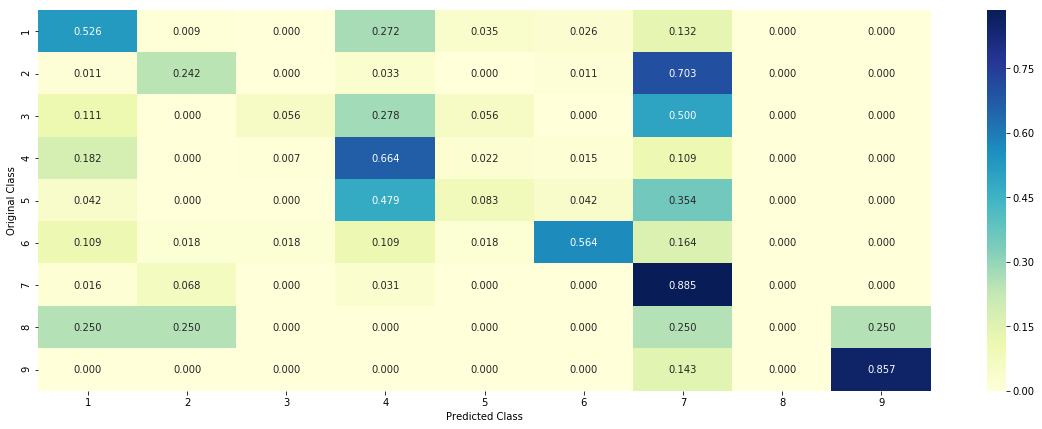

In [38]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(D_train_onehot_bow, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_onehot_bow, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_bow)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(D_train_onehot_bow, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_bow, Y_train)

predict_y = sig_clf.predict_proba(D_train_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.5.2 SGD(hindge loss) - on TF-IDF (with class balance)</h3>

for alpha = 1e-06
Log Loss : 1.2227346100865737
for alpha = 1e-05
Log Loss : 1.2100112538505141
for alpha = 0.0001
Log Loss : 1.2061096398581659
for alpha = 0.001
Log Loss : 1.2457180560345837
for alpha = 0.01
Log Loss : 1.3329197880858954
for alpha = 0.1
Log Loss : 1.33670177997753
for alpha = 1
Log Loss : 1.3349909871329828
for alpha = 10
Log Loss : 1.348069913123928
for alpha = 100
Log Loss : 1.4548690236844393


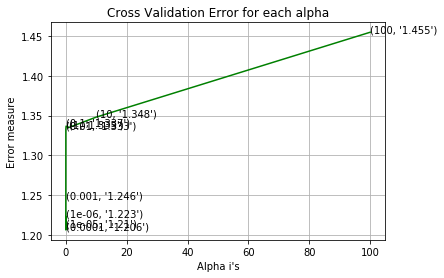

For values of best alpha =  0.0001 The train log loss is: 0.55176653202589
For values of best alpha =  0.0001 The cross validation log loss is: 1.2061096398581659
For values of best alpha =  0.0001 The test log loss is: 1.2119047720884697
Number of missclassified points:  43.91 %
-------------------- Confusion matrix --------------------


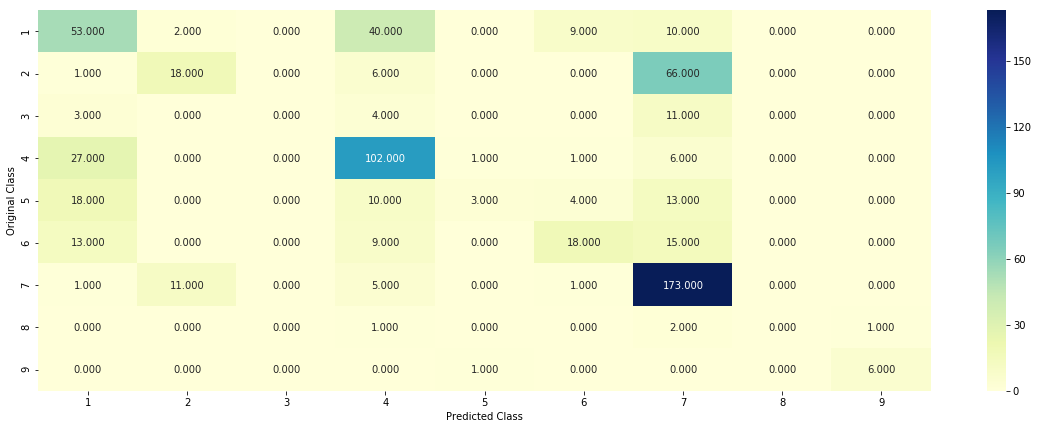

-------------------- Precision matrix (Columm Sum=1) --------------------


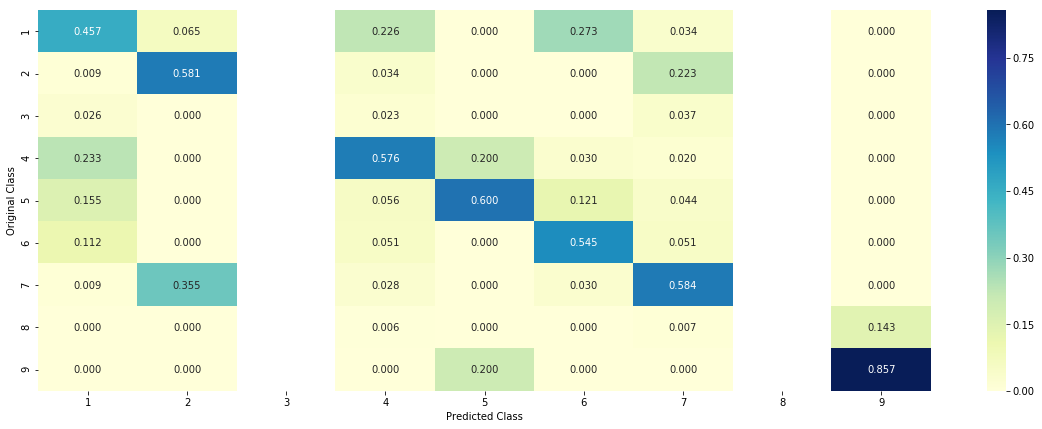

-------------------- Recall matrix (Row sum=1) --------------------


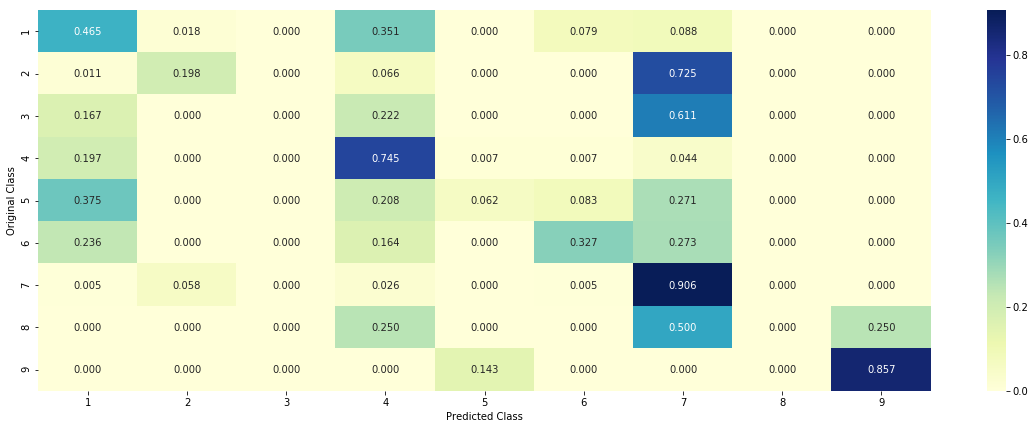

In [39]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(D_train_onehot_tfidf, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(D_train_onehot_tfidf, Y_train)
    sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_tfidf)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_tfidf, Y_train)

predict_y = sig_clf.predict_proba(D_train_onehot_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h2>4.6 Random Forest Classifier</h2>

<h3>4.6.1 Random Forest - on onehot BOW</h3>

for n_estimators = 100 and max depth =  5
Log Loss : 1.2715519513296212
for n_estimators = 100 and max depth =  10
Log Loss : 1.1623913316618766
for n_estimators = 200 and max depth =  5
Log Loss : 1.2363333481070555
for n_estimators = 200 and max depth =  10
Log Loss : 1.1468198253456077
for n_estimators = 500 and max depth =  5
Log Loss : 1.2120502426111557
for n_estimators = 500 and max depth =  10
Log Loss : 1.1390184824670497
for n_estimators = 1000 and max depth =  5
Log Loss : 1.212079177222543
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1384222302869396
for n_estimators = 2000 and max depth =  5
Log Loss : 1.206678142574961
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1376024737300643
For values of best estimator =  2000 The train log loss is: 0.6744032392769005
For values of best estimator =  2000 The cross validation log loss is: 1.1376024737300643
For values of best estimator =  2000 The test log loss is: 1.1175158761954367
Number of missclassified p

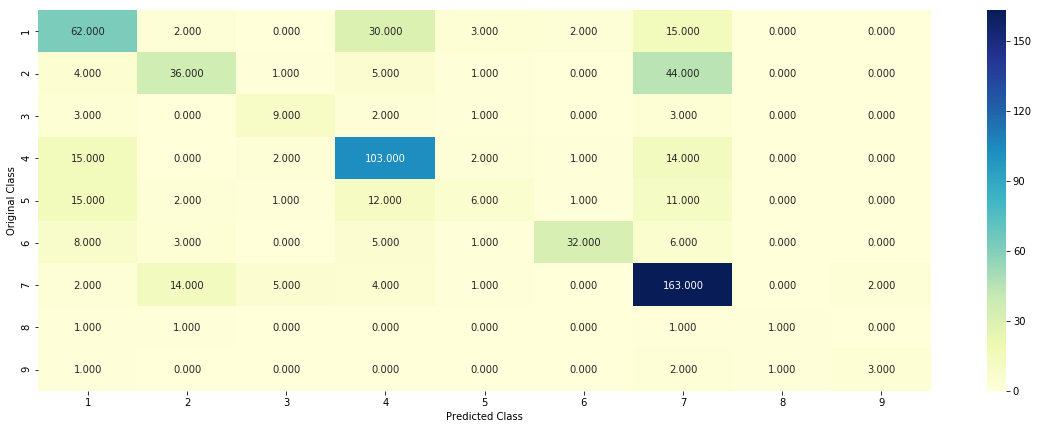

-------------------- Precision matrix (Columm Sum=1) --------------------


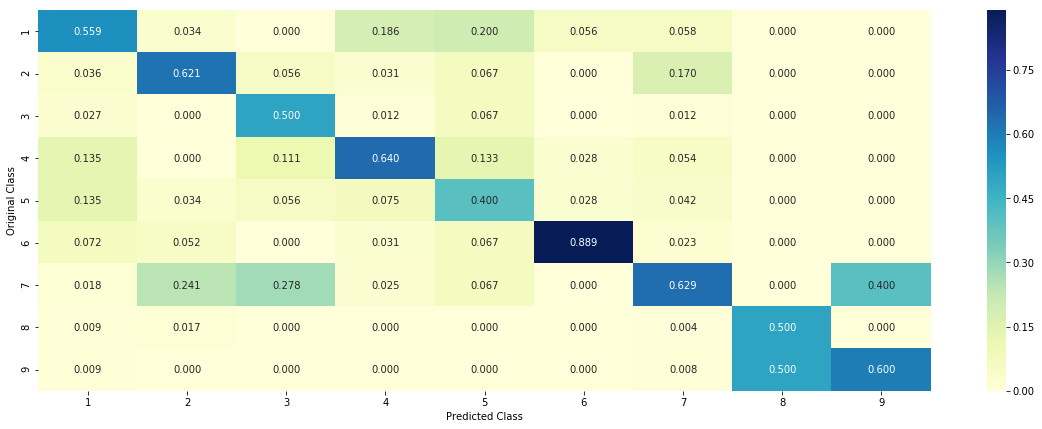

-------------------- Recall matrix (Row sum=1) --------------------


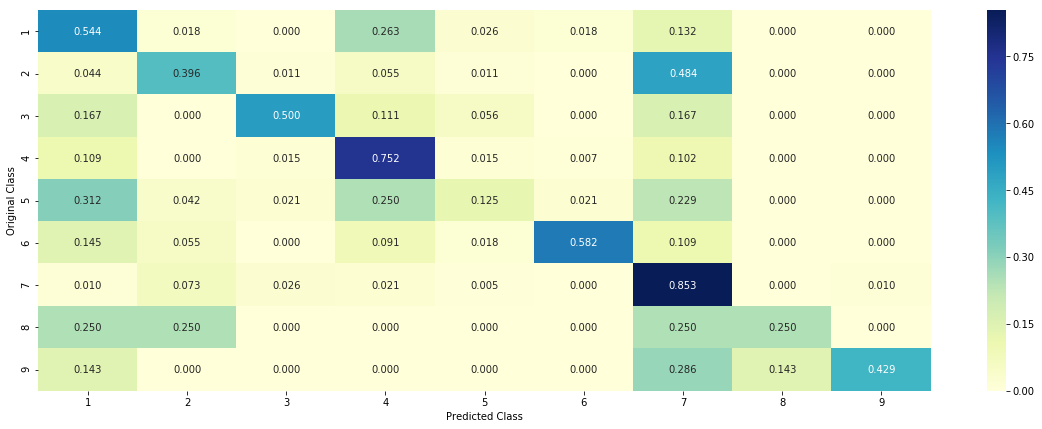

In [40]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1,class_weight = 'balanced')
        clf.fit(D_train_onehot_bow, Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(D_train_onehot_bow, Y_train)
        sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_bow)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1,class_weight = 'balanced')
clf.fit(D_train_onehot_bow, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_bow, Y_train)

predict_y = sig_clf.predict_proba(D_train_onehot_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.6.2 Random Forest - on onehot TF-IDF</h3>

for n_estimators = 100 and max depth =  5
Log Loss : 1.4414435412026985
for n_estimators = 100 and max depth =  10
Log Loss : 1.368821895803152
for n_estimators = 200 and max depth =  5
Log Loss : 1.4094558549192358
for n_estimators = 200 and max depth =  10
Log Loss : 1.3551065178665083
for n_estimators = 500 and max depth =  5
Log Loss : 1.383266042177693
for n_estimators = 500 and max depth =  10
Log Loss : 1.3447090306116252
for n_estimators = 1000 and max depth =  5
Log Loss : 1.372271219207487
for n_estimators = 1000 and max depth =  10
Log Loss : 1.3353586948680807
for n_estimators = 2000 and max depth =  5
Log Loss : 1.3676962164052222
for n_estimators = 2000 and max depth =  10
Log Loss : 1.331463296159819
For values of best estimator =  2000 The train log loss is: 1.0819136820027815
For values of best estimator =  2000 The cross validation log loss is: 1.331463296159819
For values of best estimator =  2000 The test log loss is: 1.3010741962667853
Number of missclassified poin

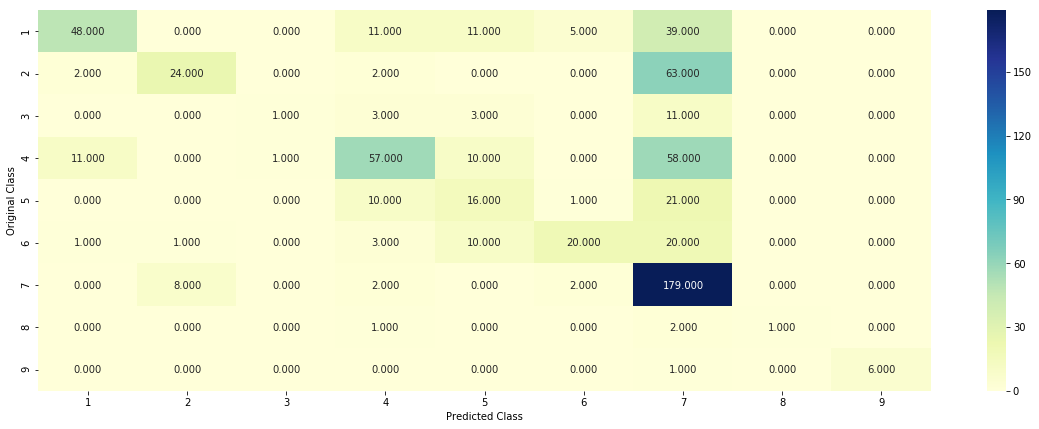

-------------------- Precision matrix (Columm Sum=1) --------------------


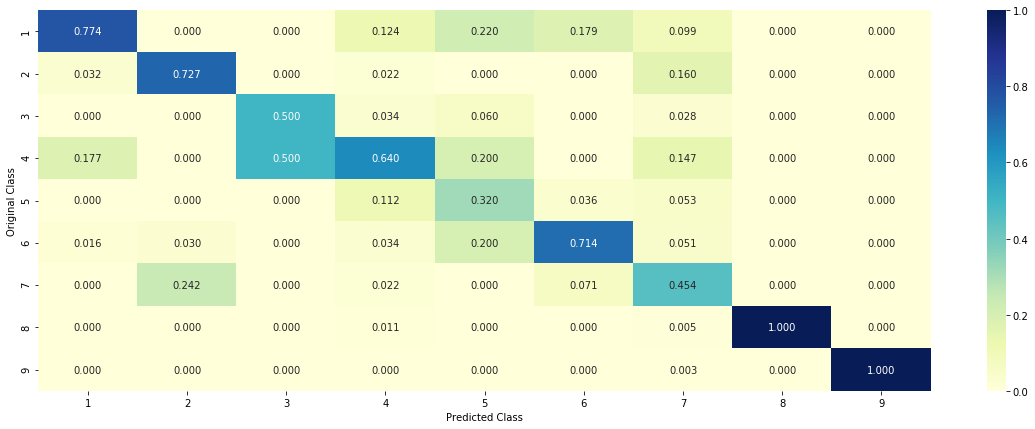

-------------------- Recall matrix (Row sum=1) --------------------


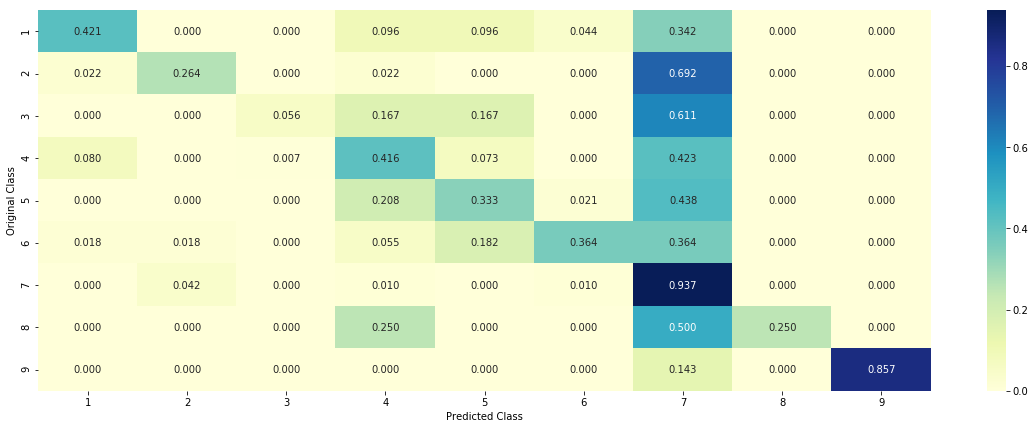

In [41]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1,class_weight = 'balanced')
        clf.fit(D_train_onehot_tfidf, Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(D_train_onehot_tfidf, Y_train)
        sig_clf_probs = sig_clf.predict_proba(D_cv_onehot_tfidf)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1,class_weight = 'balanced')
clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_onehot_tfidf, Y_train)

predict_y = sig_clf.predict_proba(D_train_onehot_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_onehot_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_onehot_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_onehot_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.6.3 Random Forest - on response BOW</h3>

for n_estimators = 100 and max depth =  5
Log Loss : 1.2301950930020422
for n_estimators = 100 and max depth =  10
Log Loss : 1.072731393574474
for n_estimators = 200 and max depth =  5
Log Loss : 1.1992358063058794
for n_estimators = 200 and max depth =  10
Log Loss : 1.0638110995403252
for n_estimators = 500 and max depth =  5
Log Loss : 1.1790940242831387
for n_estimators = 500 and max depth =  10
Log Loss : 1.0584031057675607
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1695221170348216
for n_estimators = 1000 and max depth =  10
Log Loss : 1.0588979170066042
for n_estimators = 2000 and max depth =  5
Log Loss : 1.170603078930466
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0576828567022405
For values of best estimator =  2000 The train log loss is: 0.5557323470256249
For values of best estimator =  2000 The cross validation log loss is: 1.0576828567022405
For values of best estimator =  2000 The test log loss is: 1.045816079021999
Number of missclassified po

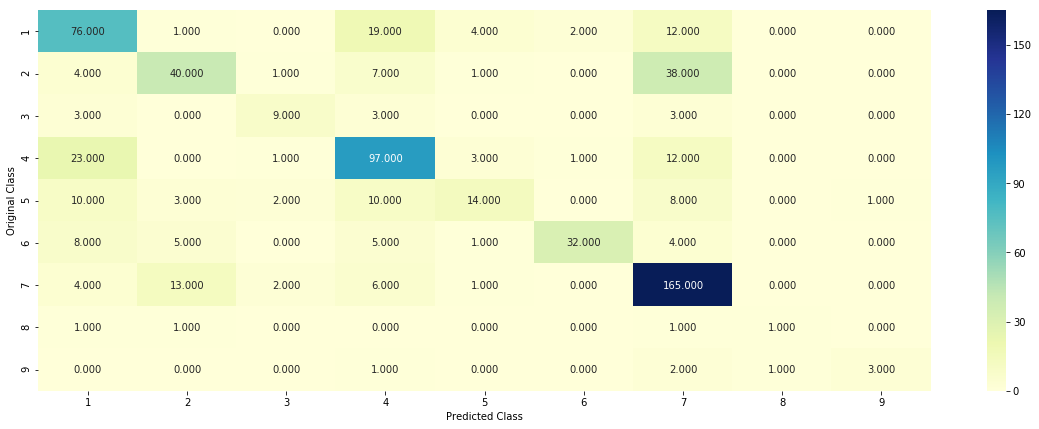

-------------------- Precision matrix (Columm Sum=1) --------------------


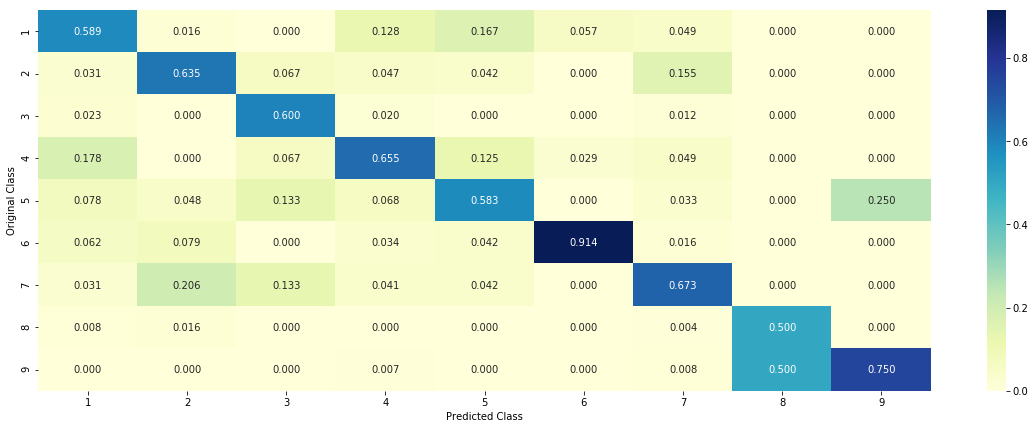

-------------------- Recall matrix (Row sum=1) --------------------


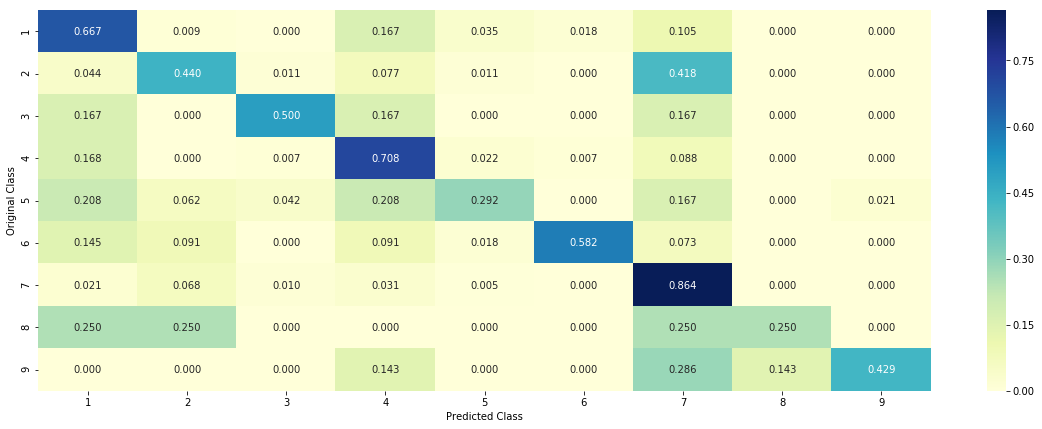

In [42]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1,class_weight = 'balanced')
        clf.fit(D_train_response_bow, Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(D_train_response_bow, Y_train)
        sig_clf_probs = sig_clf.predict_proba(D_cv_response_bow)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1,class_weight = 'balanced')
clf.fit(D_train_response_bow, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_response_bow, Y_train)

predict_y = sig_clf.predict_proba(D_train_response_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_response_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_response_bow)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_response_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.6.4 Random Forest - on response TF-IDF</h3>

for n_estimators = 100 and max depth =  5
Log Loss : 1.6299709385900738
for n_estimators = 100 and max depth =  10
Log Loss : 1.5868574692314064
for n_estimators = 200 and max depth =  5
Log Loss : 1.6308850353836342
for n_estimators = 200 and max depth =  10
Log Loss : 1.5865087493391878
for n_estimators = 500 and max depth =  5
Log Loss : 1.634568459065711
for n_estimators = 500 and max depth =  10
Log Loss : 1.5833446201244672
for n_estimators = 1000 and max depth =  5
Log Loss : 1.6311818187062435
for n_estimators = 1000 and max depth =  10
Log Loss : 1.5813927744381628
for n_estimators = 2000 and max depth =  5
Log Loss : 1.6321821500699807
for n_estimators = 2000 and max depth =  10
Log Loss : 1.585082339507597
For values of best estimator =  1000 The train log loss is: 1.266035083682048
For values of best estimator =  1000 The cross validation log loss is: 1.5813927743841765
For values of best estimator =  1000 The test log loss is: 1.5250826473873422
Number of missclassified po

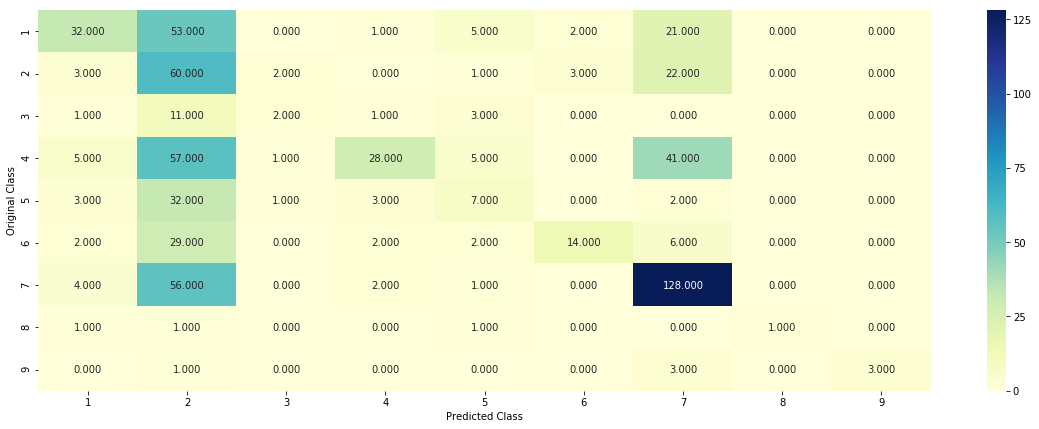

-------------------- Precision matrix (Columm Sum=1) --------------------


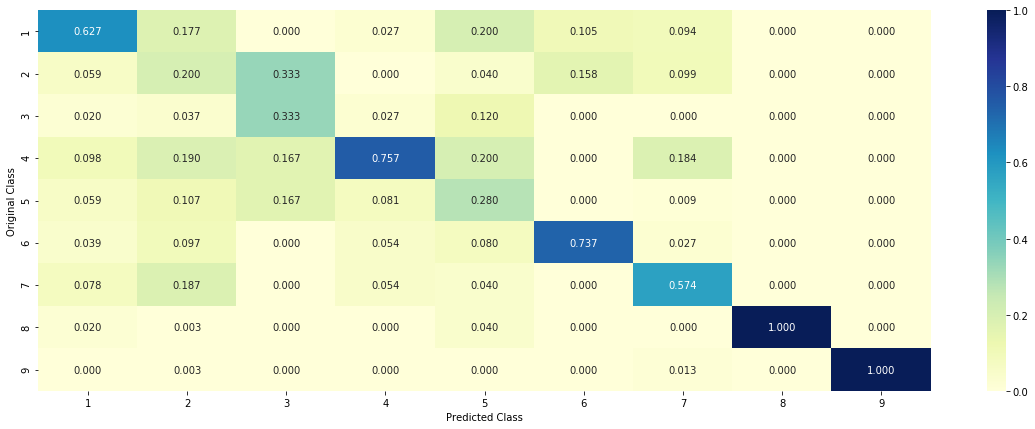

-------------------- Recall matrix (Row sum=1) --------------------


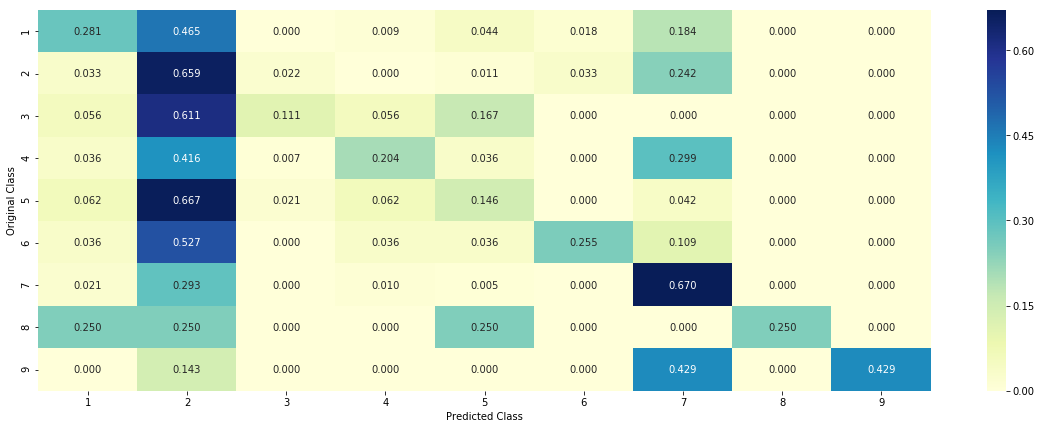

In [43]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1,class_weight = 'balanced')
        clf.fit(D_train_response_tfidf, Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(D_train_response_tfidf, Y_train)
        sig_clf_probs = sig_clf.predict_proba(D_cv_response_tfidf)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', 
                             max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1,class_weight = 'balanced')
clf.fit(D_train_response_tfidf, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(D_train_response_tfidf, Y_train)

predict_y = sig_clf.predict_proba(D_train_response_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_cv_response_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(D_test_response_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Miss classification rate on test data:
predicted_class = sig_clf.predict(D_test_response_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h2>4.7 Stacking models</h2>

<h3>4.7.1 Stacking model on onehot encoded + BOW</h3>

KNN :  Log Loss: 1.22
Logistic Regression : Log Loss: 1.19
Random Forest : Log Loss: 1.14
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.185
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.094
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.654
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.170
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.273
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.816
Log loss (train) on the stacking model : 0.05156585508580851
Log loss (CV) on the stacking model : 1.48809887189117
Log loss (test) on the stacking model : 1.4861265319257015
Number of missclassified points:  38.35 %
-------------------- Confusion matrix --------------------


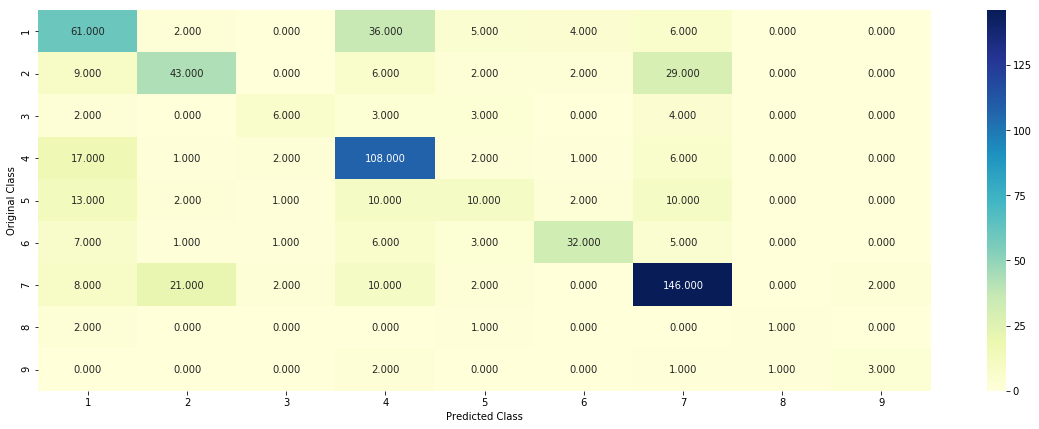

-------------------- Precision matrix (Columm Sum=1) --------------------


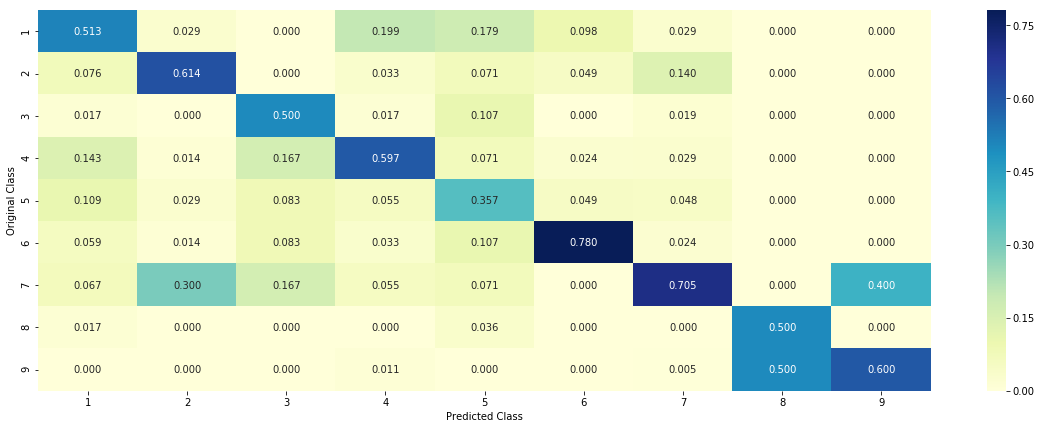

-------------------- Recall matrix (Row sum=1) --------------------


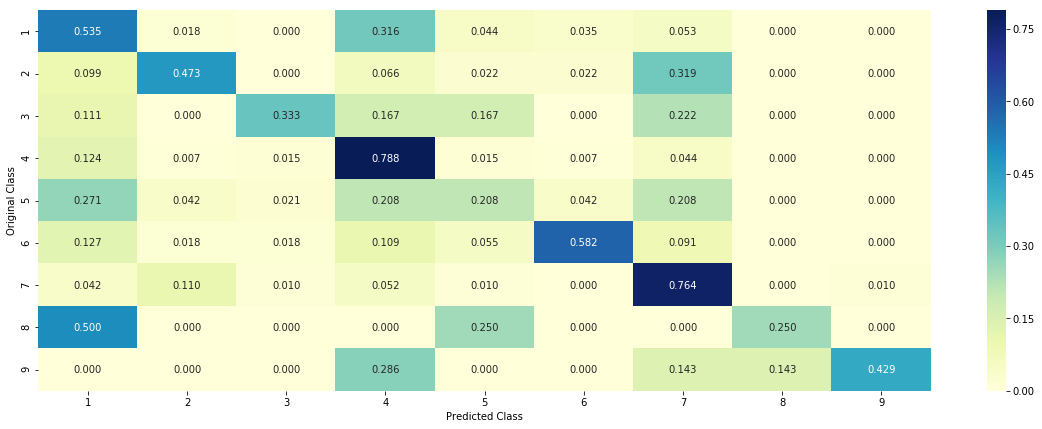

In [44]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_onehot_bow, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_onehot_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_onehot_bow, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_onehot_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_onehot_bow, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_onehot_bow, Y_train)


print("KNN :  Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf1.predict_proba(D_cv_onehot_bow))))
print("Logistic Regression : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf2.predict_proba(D_cv_onehot_bow))))
print("Random Forest : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf3.predict_proba(D_cv_onehot_bow))))
print("-"*50)


cv_log_error_array = list()
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(class_weight='balanced', C=i, penalty='l2', n_jobs=-1)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(D_train_onehot_bow, Y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_bow))))
    log_error = log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_bow))
    cv_log_error_array.append(log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_bow), labels=clf.classes_, eps=1e-15))
    if best_alpha > log_error:
        best_alpha = log_error

best_alpha = np.argmin(cv_log_error_array)

lr = LogisticRegression(class_weight='balanced', C=best_alpha, penalty='l2', n_jobs=-1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(D_train_onehot_bow, Y_train)        
        
print("Log loss (train) on the stacking model :", log_loss(Y_train, sclf.predict_proba(D_train_onehot_bow)))
print("Log loss (CV) on the stacking model :", log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_bow)))
print("Log loss (test) on the stacking model :", log_loss(Y_test, sclf.predict_proba(D_test_onehot_bow)))

# Miss classification rate on test data:
predicted_class = sclf.predict(D_test_onehot_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)        

<h3>4.7.2 Stacking model on response encoded + BOW</h3>

KNN :  Log Loss: 1.15
Logistic Regression : Log Loss: 1.19
Random Forest : Log Loss: 1.06
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.184
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.083
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.601
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.108
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.190
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.672
Log loss (train) on the stacking model : 0.06451480044790242
Log loss (CV) on the stacking model : 1.380308037587374
Log loss (test) on the stacking model : 1.4140840737913267
Number of missclassified points:  35.79 %
-------------------- Confusion matrix --------------------


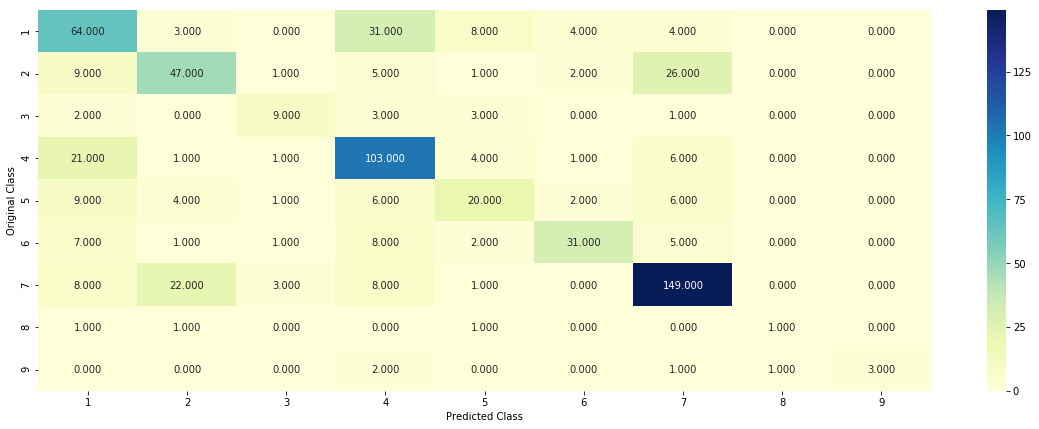

-------------------- Precision matrix (Columm Sum=1) --------------------


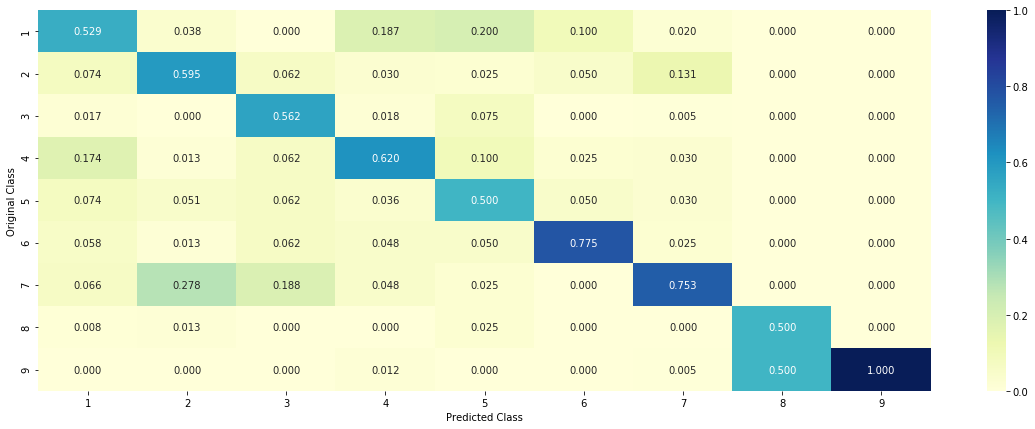

-------------------- Recall matrix (Row sum=1) --------------------


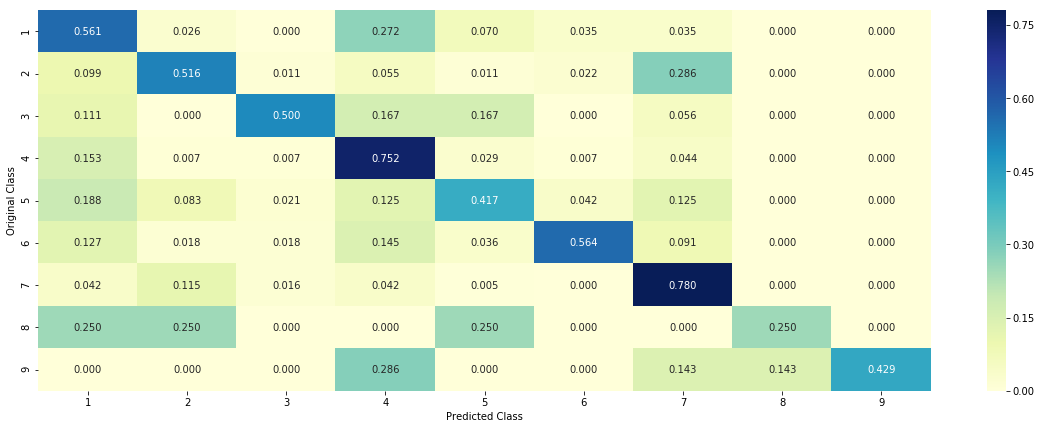

In [45]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_response_bow, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_response_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_response_bow, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_response_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_response_bow, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_response_bow, Y_train)


print("KNN :  Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf1.predict_proba(D_cv_response_bow))))
print("Logistic Regression : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf2.predict_proba(D_cv_response_bow))))
print("Random Forest : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf3.predict_proba(D_cv_response_bow))))
print("-"*50)

cv_log_error_array = list()
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(class_weight='balanced', C=i, penalty='l2', n_jobs=-1)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(D_train_response_bow, Y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(Y_cv, sclf.predict_proba(D_cv_response_bow))))
    log_error = log_loss(Y_cv, sclf.predict_proba(D_cv_response_bow))
    cv_log_error_array.append(log_loss(Y_cv, sclf.predict_proba(D_cv_response_bow), labels=clf.classes_, eps=1e-15))
    if best_alpha > log_error:
        best_alpha = log_error

best_alpha = np.argmin(cv_log_error_array)

lr = LogisticRegression(class_weight='balanced', C=best_alpha, penalty='l2', n_jobs=-1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(D_train_response_bow, Y_train)        
        
print("Log loss (train) on the stacking model :", log_loss(Y_train, sclf.predict_proba(D_train_response_bow)))
print("Log loss (CV) on the stacking model :", log_loss(Y_cv, sclf.predict_proba(D_cv_response_bow)))
print("Log loss (test) on the stacking model :", log_loss(Y_test, sclf.predict_proba(D_test_response_bow)))

# Miss classification rate on test data:
predicted_class = sclf.predict(D_test_response_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)       

<h3>4.7.3 Stacking model on onehot encoded + TF-IDF</h3>

KNN :  Log Loss: 1.22
Logistic Regression : Log Loss: 1.31
Random Forest : Log Loss: 1.33
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.186
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.108
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.726
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.278
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.444
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.001
Log loss (train) on the stacking model : 0.04542434806069872
Log loss (CV) on the stacking model : 1.675400955003117
Log loss (test) on the stacking model : 1.5469283333806845
Number of missclassified points:  41.5 %
-------------------- Confusion matrix --------------------


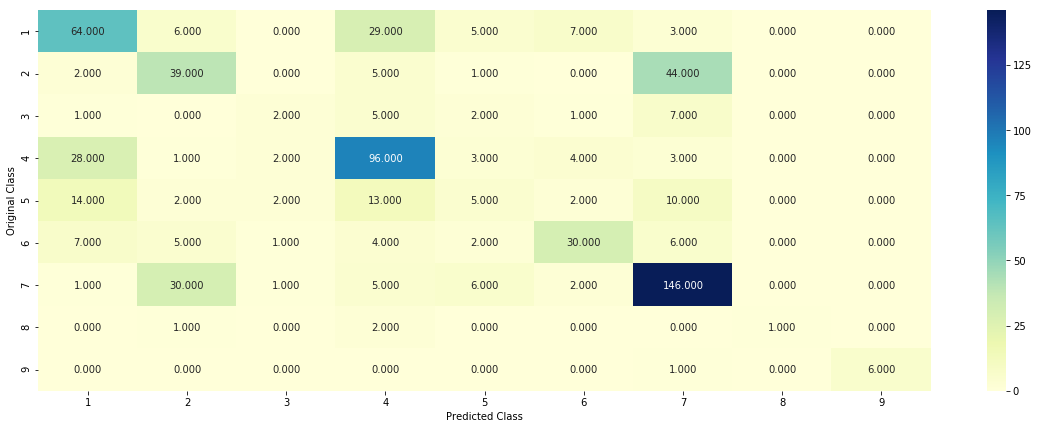

-------------------- Precision matrix (Columm Sum=1) --------------------


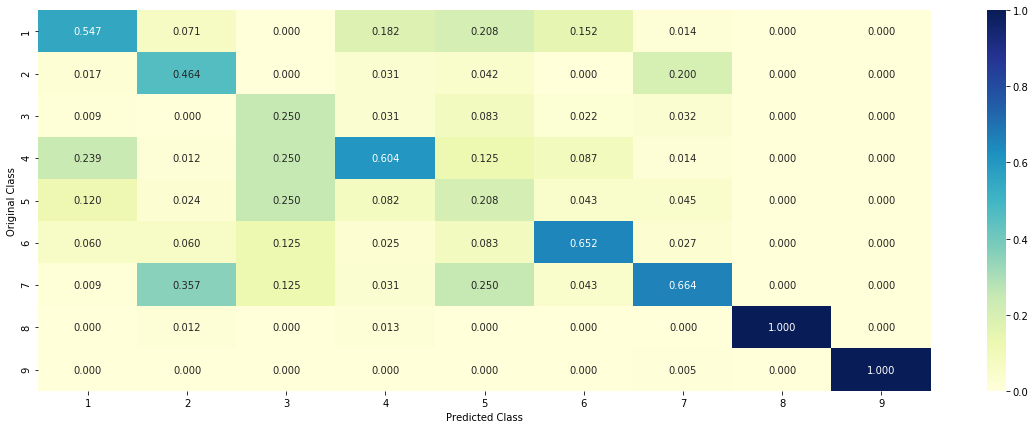

-------------------- Recall matrix (Row sum=1) --------------------


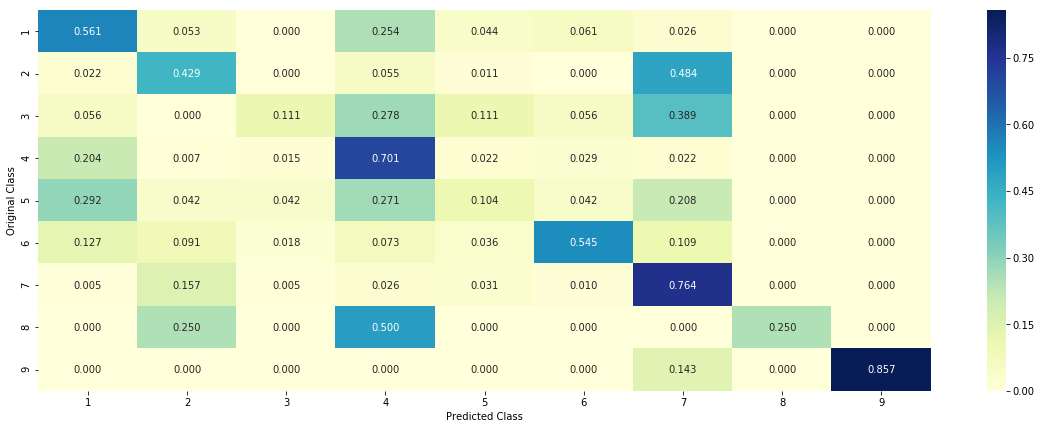

In [46]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_onehot_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_onehot_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_onehot_tfidf, Y_train)


print("KNN :  Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf1.predict_proba(D_cv_onehot_tfidf))))
print("Logistic Regression : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf2.predict_proba(D_cv_onehot_tfidf))))
print("Random Forest : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf3.predict_proba(D_cv_onehot_tfidf))))
print("-"*50)

cv_log_error_array = list()
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(class_weight='balanced', C=i, penalty='l2', n_jobs=-1)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(D_train_onehot_tfidf, Y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_tfidf))))
    log_error =log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_tfidf))
    cv_log_error_array.append(log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_tfidf), labels=clf.classes_, eps=1e-15))
    if best_alpha > log_error:
        best_alpha = log_error
        
        
best_alpha = np.argmin(cv_log_error_array)

lr = LogisticRegression(class_weight='balanced', C=best_alpha, penalty='l2', n_jobs=-1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(D_train_onehot_tfidf, Y_train)        
        
print("Log loss (train) on the stacking model :", log_loss(Y_train, sclf.predict_proba(D_train_onehot_tfidf)))
print("Log loss (CV) on the stacking model :", log_loss(Y_cv, sclf.predict_proba(D_cv_onehot_tfidf)))
print("Log loss (test) on the stacking model :", log_loss(Y_test, sclf.predict_proba(D_test_onehot_tfidf)))

# Miss classification rate on test data:
predicted_class = sclf.predict(D_test_onehot_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)          

<h3>4.7.4 Stacking model on response encoded + TF-IDF</h3>

KNN :  Log Loss: 2.09
Logistic Regression : Log Loss: 1.76
Random Forest : Log Loss: 1.59
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.190
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.145
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 2.001
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 2.062
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 2.530
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.817
Log loss (train) on the stacking model : 0.35645215884557796
Log loss (CV) on the stacking model : 2.6528326764034174
Log loss (test) on the stacking model : 2.633143556824339
Number of missclassified points:  67.82 %
-------------------- Confusion matrix --------------------


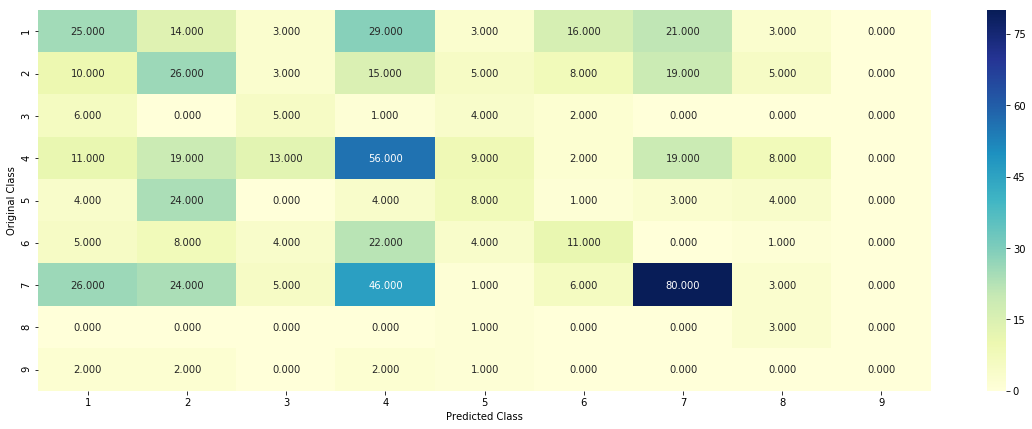

-------------------- Precision matrix (Columm Sum=1) --------------------


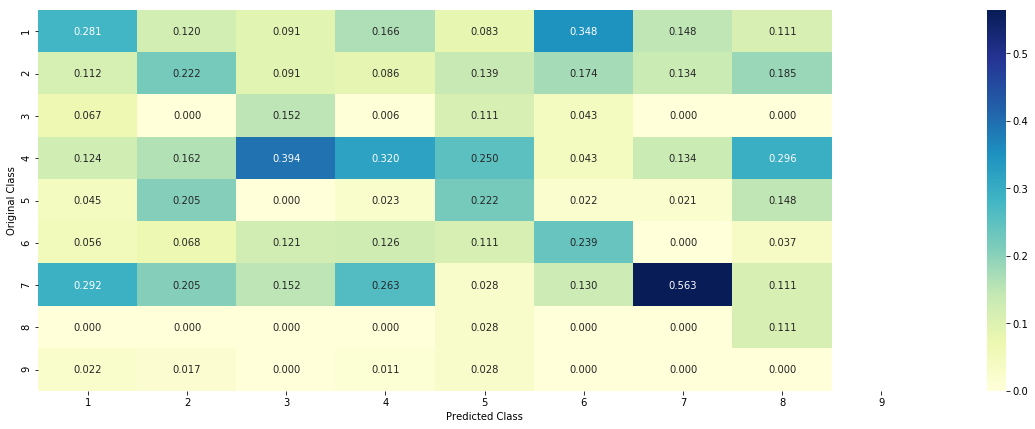

-------------------- Recall matrix (Row sum=1) --------------------


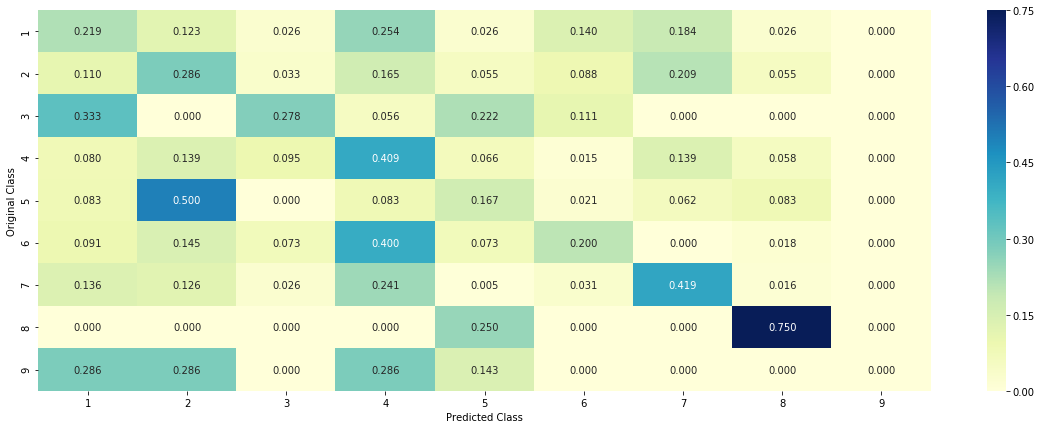

In [47]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_response_tfidf, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_response_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_response_tfidf, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_response_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_response_tfidf, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_response_tfidf, Y_train)


print("KNN :  Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf1.predict_proba(D_cv_response_tfidf))))
print("Logistic Regression : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf2.predict_proba(D_cv_response_tfidf))))
print("Random Forest : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf3.predict_proba(D_cv_response_tfidf))))
print("-"*50)

cv_log_error_array = list()
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(class_weight='balanced', C=i, penalty='l2', n_jobs=-1)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(D_train_response_tfidf, Y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(Y_cv, sclf.predict_proba(D_cv_response_tfidf))))
    log_error =log_loss(Y_cv, sclf.predict_proba(D_cv_response_tfidf))
    cv_log_error_array.append(log_loss(Y_cv, sclf.predict_proba(D_cv_response_tfidf), labels=clf.classes_, eps=1e-15))
    if best_alpha > log_error:
        best_alpha = log_error

best_alpha = np.argmin(cv_log_error_array)

lr = LogisticRegression(class_weight='balanced', C=best_alpha, penalty='l2', n_jobs=-1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(D_train_response_tfidf, Y_train)        

print("Log loss (train) on the stacking model :", log_loss(Y_train, sclf.predict_proba(D_train_response_tfidf)))
print("Log loss (CV) on the stacking model :", log_loss(Y_cv, sclf.predict_proba(D_cv_response_tfidf)))
print("Log loss (test) on the stacking model :", log_loss(Y_test, sclf.predict_proba(D_test_response_tfidf)))

# Miss classification rate on test data:
predicted_class = sclf.predict(D_test_response_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)          

<h2>4.8 Maximum Voting classifier </h2>

<h3>4.8.1 Maximum voting on onehot encoded + BOW</h3>

Log loss (train) on the VotingClassifier : 0.6291354307361362
Log loss (CV) on the VotingClassifier : 1.1271032856691825
Log loss (test) on the VotingClassifier : 1.126911134565376
Number of missclassified points:  36.09 %
-------------------- Confusion matrix --------------------


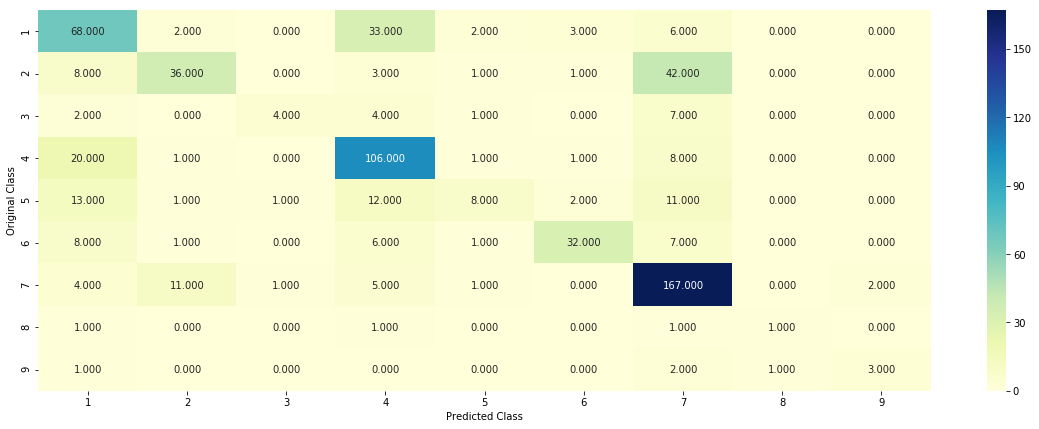

-------------------- Precision matrix (Columm Sum=1) --------------------


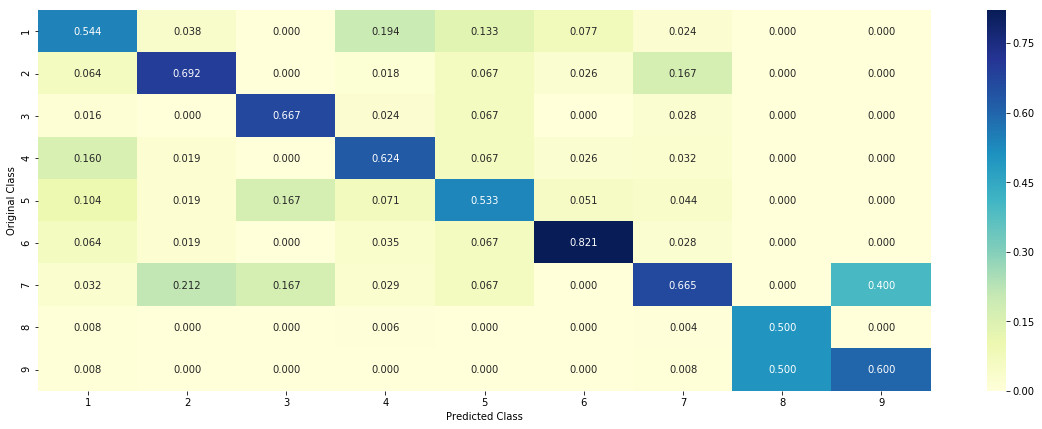

-------------------- Recall matrix (Row sum=1) --------------------


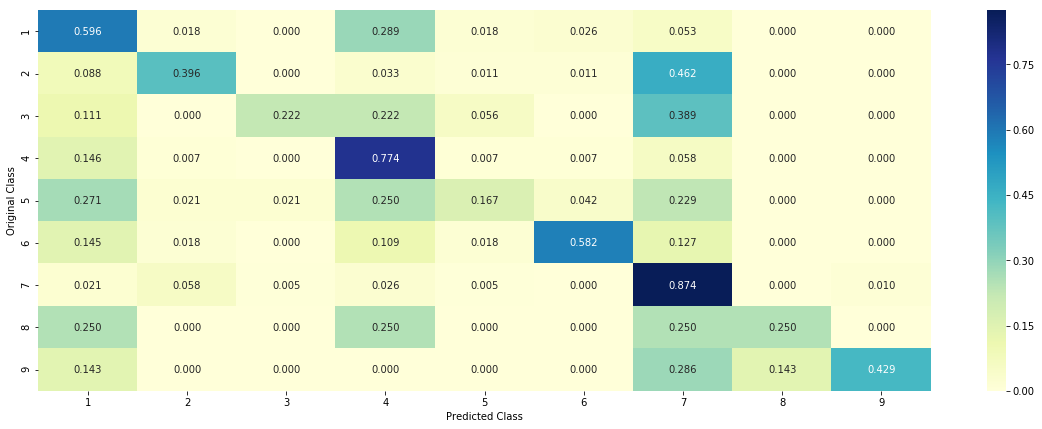

In [48]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_onehot_bow, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_onehot_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_onehot_bow, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_onehot_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_onehot_bow, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_onehot_bow, Y_train)

vclf = VotingClassifier(estimators=[('KNN', sig_clf1), ('LR', sig_clf2), ('RF', sig_clf3)], voting='soft')
vclf.fit(D_train_onehot_bow, Y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(Y_train, vclf.predict_proba(D_train_onehot_bow)))
print("Log loss (CV) on the VotingClassifier :", log_loss(Y_cv, vclf.predict_proba(D_cv_onehot_bow)))
print("Log loss (test) on the VotingClassifier :", log_loss(Y_test, vclf.predict_proba(D_test_onehot_bow)))


# Miss classification rate on test data:
predicted_class = vclf.predict(D_test_onehot_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.8.2 Maximum voting on onehot encoded + TF-IDF</h3>

Log loss (train) on the VotingClassifier : 0.7721284946647978
Log loss (CV) on the VotingClassifier : 1.226848231523356
Log loss (test) on the VotingClassifier : 1.196942470119432
Number of missclassified points:  38.5 %
-------------------- Confusion matrix --------------------


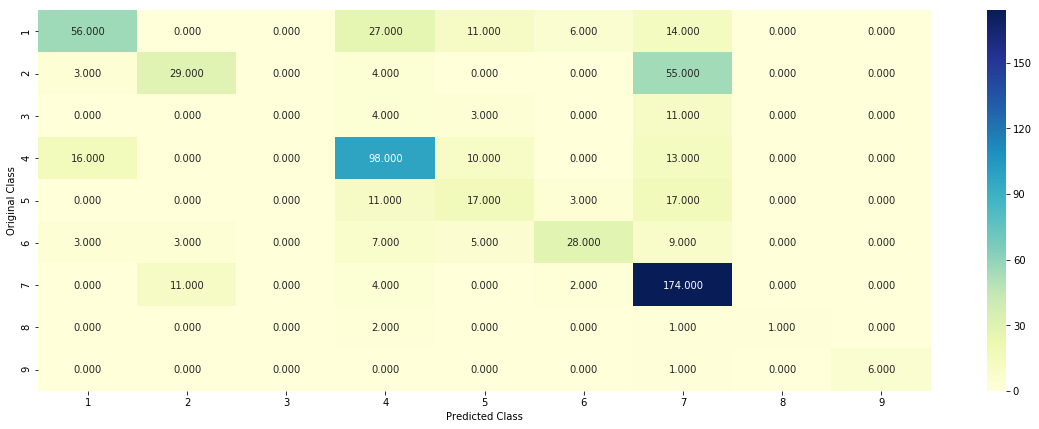

-------------------- Precision matrix (Columm Sum=1) --------------------


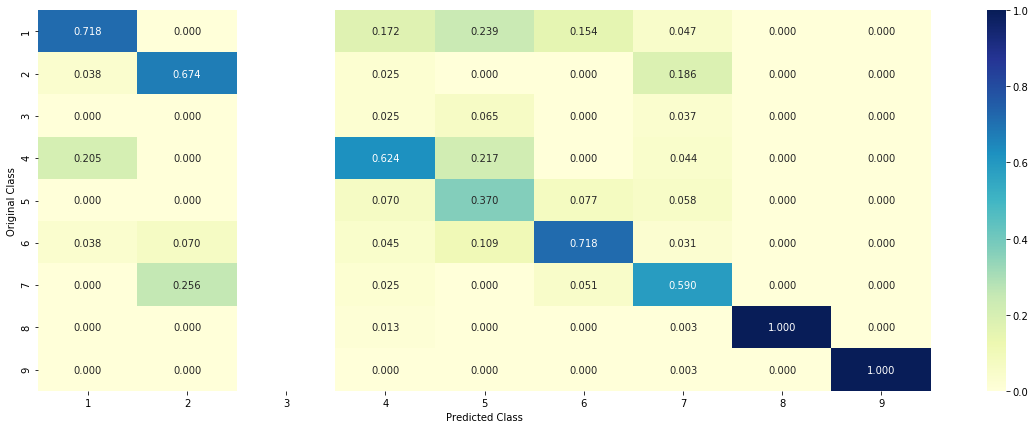

-------------------- Recall matrix (Row sum=1) --------------------


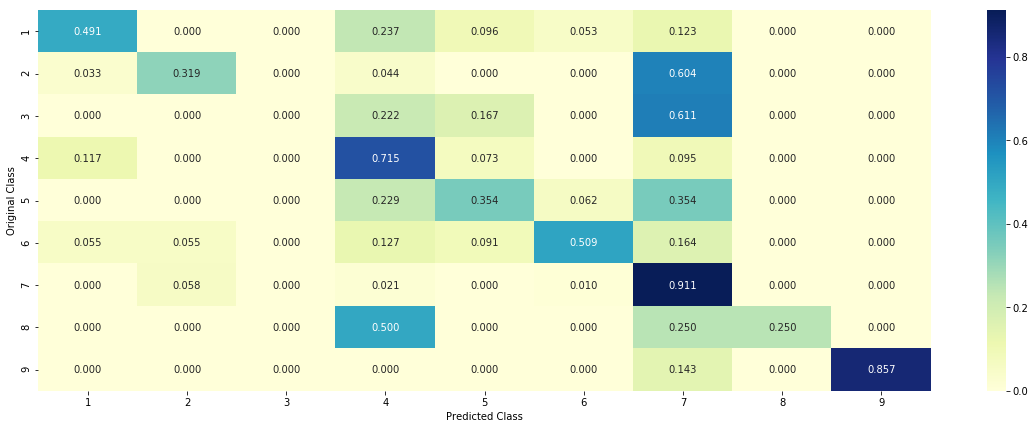

In [49]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_onehot_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_onehot_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_onehot_tfidf, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_onehot_tfidf, Y_train)

vclf = VotingClassifier(estimators=[('KNN', sig_clf1), ('LR', sig_clf2), ('RF', sig_clf3)], voting='soft')
vclf.fit(D_train_onehot_tfidf, Y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(Y_train, vclf.predict_proba(D_train_onehot_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(Y_cv, vclf.predict_proba(D_cv_onehot_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(Y_test, vclf.predict_proba(D_test_onehot_tfidf)))

# Miss classification rate on test data:
predicted_class = vclf.predict(D_test_onehot_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.8.3 Maximum voting on response encoded + BOW</h3>

Log loss (train) on the VotingClassifier : 0.5748952924189277
Log loss (CV) on the VotingClassifier : 1.072750249577574
Log loss (test) on the VotingClassifier : 1.0821608274514052
Number of missclassified points:  33.83 %
-------------------- Confusion matrix --------------------


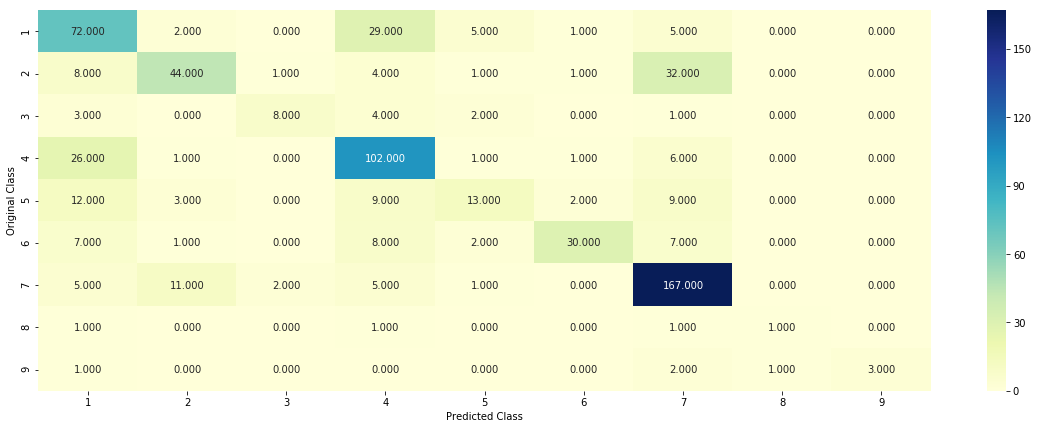

-------------------- Precision matrix (Columm Sum=1) --------------------


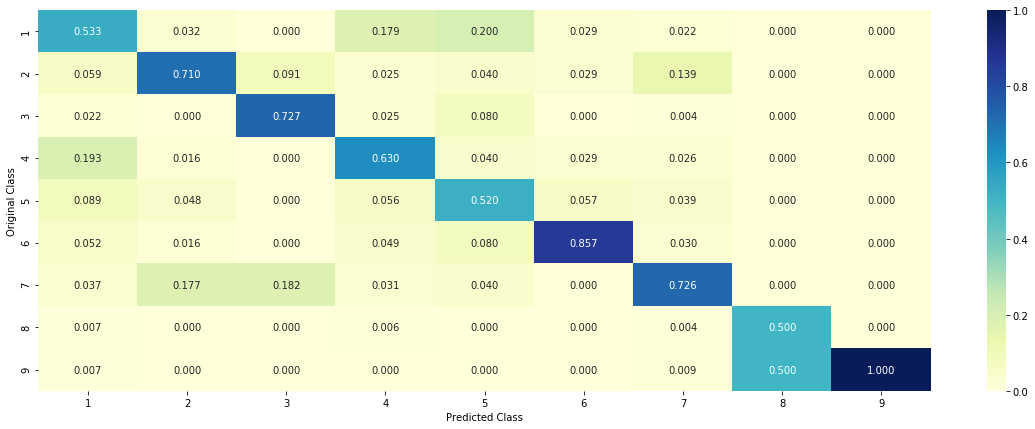

-------------------- Recall matrix (Row sum=1) --------------------


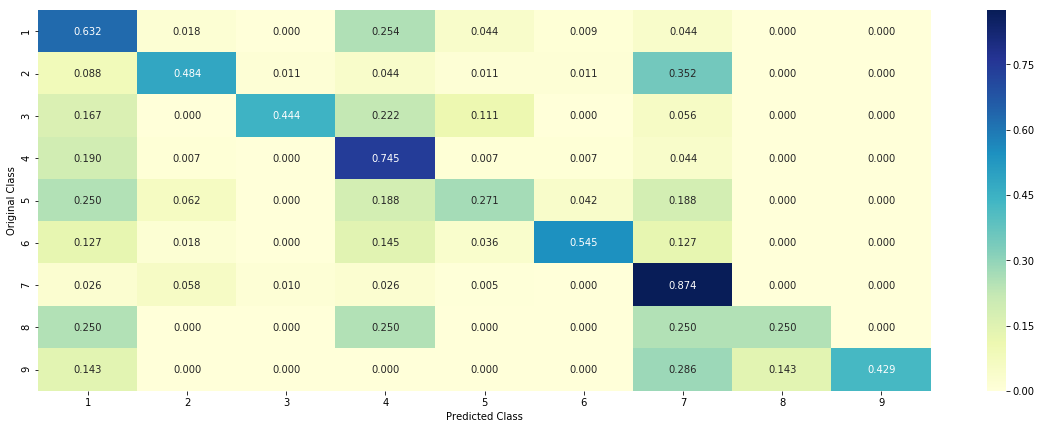

In [50]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_response_bow, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_response_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_response_bow, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_response_bow, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_response_bow, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_response_bow, Y_train)

vclf = VotingClassifier(estimators=[('KNN', sig_clf1), ('LR', sig_clf2), ('RF', sig_clf3)], voting='soft')
vclf.fit(D_train_response_bow, Y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(Y_train, vclf.predict_proba(D_train_response_bow)))
print("Log loss (CV) on the VotingClassifier :", log_loss(Y_cv, vclf.predict_proba(D_cv_response_bow)))
print("Log loss (test) on the VotingClassifier :", log_loss(Y_test, vclf.predict_proba(D_test_response_bow)))

# Miss classification rate on test data:
predicted_class = vclf.predict(D_test_response_bow)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h3>4.8.4 Maximum voting on response encoded + TF-IDF</h3>

Log loss (train) on the VotingClassifier : 0.9110540555139205
Log loss (CV) on the VotingClassifier : 1.6303447252590995
Log loss (test) on the VotingClassifier : 1.5859572757945057
Number of missclassified points:  62.26 %
-------------------- Confusion matrix --------------------


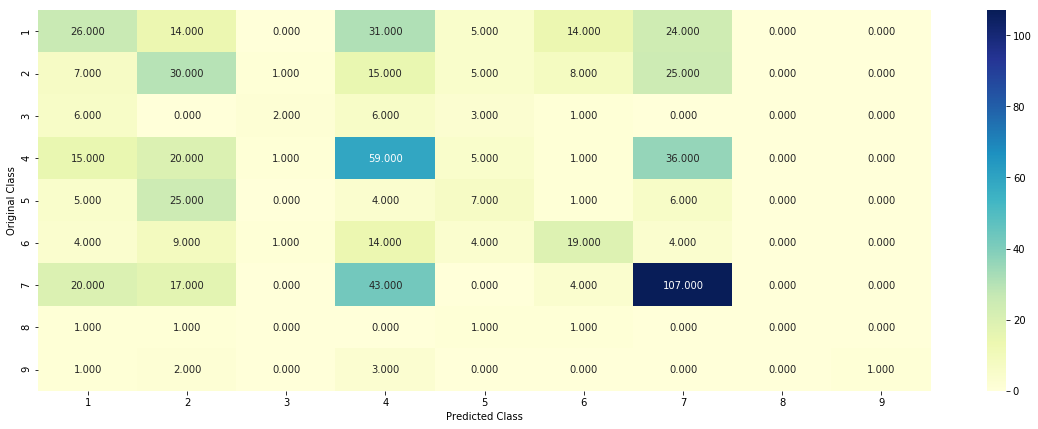

-------------------- Precision matrix (Columm Sum=1) --------------------


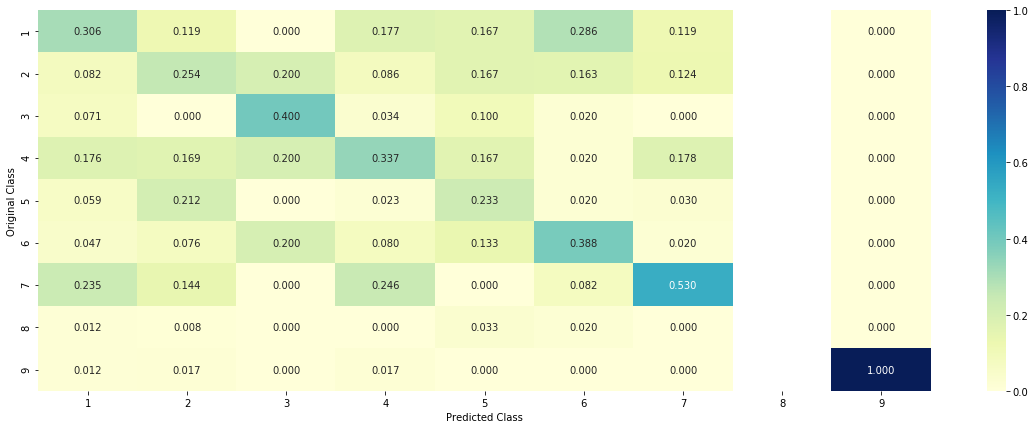

-------------------- Recall matrix (Row sum=1) --------------------


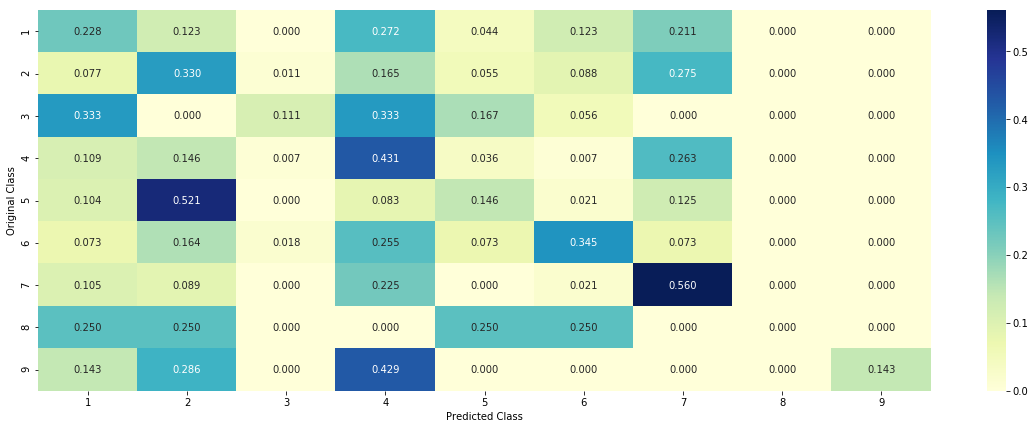

In [51]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_response_tfidf, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_response_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_response_tfidf, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_response_tfidf, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_response_tfidf, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_response_tfidf, Y_train)

vclf = VotingClassifier(estimators=[('KNN', sig_clf1), ('LR', sig_clf2), ('RF', sig_clf3)], voting='soft')
vclf.fit(D_train_response_tfidf, Y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(Y_train, vclf.predict_proba(D_train_response_tfidf)))
print("Log loss (CV) on the VotingClassifier :", log_loss(Y_cv, vclf.predict_proba(D_cv_response_tfidf)))
print("Log loss (test) on the VotingClassifier :", log_loss(Y_test, vclf.predict_proba(D_test_response_tfidf)))

# Miss classification rate on test data:
predicted_class = vclf.predict(D_test_response_tfidf)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h2>5 Feature Engineering </h2>

After applying all the various models on all the various transformations, it was noted that the performance stayed relatively the same. Now it is time to perform some extra featurisation - I decided to use the jaccard distance which models the amount (%) overlap of the gene feature compared to each of the classses.

In [52]:
def jaccard_distance(X,Y):
    X = set(X)
    Y = set(Y)
    return len(X.intersection(Y))/len(X.union(Y))

In [53]:
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [54]:
# understanding the amount of overlap per gene feature set comparing different classes.
dic = dict()
for i in set(result.loc[:,'Class'].values): #for each unique class
    X = set(result.query('Class == @i').loc[:,'Gene'].values) #unique gene values for the class
    for j in set(result.loc[:,'Class'].values): #for each unique class
        Y = set(result.query('Class == @j').loc[:,'Gene'].values) #unique gene values for the class
        if i in dic.keys():
            dic[i].append(round(jaccard_distance(X,Y),2))
        else:
            dic[i] = [round(jaccard_distance(X,Y),2)]
# The gene overlap for class i with class i will be 1, but the gene overlap for class i with class j will be different

In [55]:
# 9 features per class (note the diagonal contains 1)
jaccard = pd.DataFrame(data=dic)
jaccard['class'] = jaccard.index.values + 1
jaccard

,1,2,3,4,5,6,7,8,9,class
0,1.00,0.16,0.11,0.40,0.25,0.18,0.12,0.03,0.03,1
1,0.16,1.00,0.14,0.15,0.20,0.23,0.51,0.06,0.03,2
2,0.11,0.14,1.00,0.15,0.23,0.12,0.13,0.06,0.03,3
3,0.40,0.15,0.15,1.00,0.25,0.18,0.14,0.05,0.02,4
4,0.25,0.20,0.23,0.25,1.00,0.33,0.16,0.07,0.04,5
5,0.18,0.23,0.12,0.18,0.33,1.00,0.19,0.05,0.02,6
6,0.12,0.51,0.13,0.14,0.16,0.19,1.00,0.05,0.04,7
7,0.03,0.06,0.06,0.05,0.07,0.05,0.05,1.00,0.16,8
8,0.03,0.03,0.03,0.02,0.04,0.02,0.04,0.16,1.00,9


In [56]:
# construct the new arrays with the 9 extra features added:
# Here I join the jaccard information (per class) to the class response variable in the data in order to add the extra 9 features
def convert_encoding(X,Y):   
    temp = pd.DataFrame(data=Y)
    temp.columns = ['class']
    D_fe = pd.merge(pd.merge(pd.DataFrame(data=X),temp,how='inner',left_index=True,right_index=True),jaccard,how='left',left_on='class',right_on='class')
    D_fe.drop(columns=['class'],inplace=True)
    return(D_fe)

The code below makes use of the created function to add the engineerd feature to each of the datasets and then converting them to numpy arrays.

In [57]:
D_train_onehot_bow_fe = np.array(convert_encoding(X=D_train_onehot_bow,Y=Y_train))
D_cv_onehot_bow_fe = np.array(convert_encoding(X=D_cv_onehot_bow,Y=Y_cv))
D_test_onehot_bow_fe = np.array(convert_encoding(X=D_test_onehot_bow,Y=Y_test))

<h3>5.1 Maximum voting on feature engineerd dataset</h3>

Log loss (train) on the VotingClassifier : 0.39231307237274293
Log loss (CV) on the VotingClassifier : 0.6527914250256511
Log loss (test) on the VotingClassifier : 0.6530926991781959
Number of missclassified points:  12.78 %
-------------------- Confusion matrix --------------------


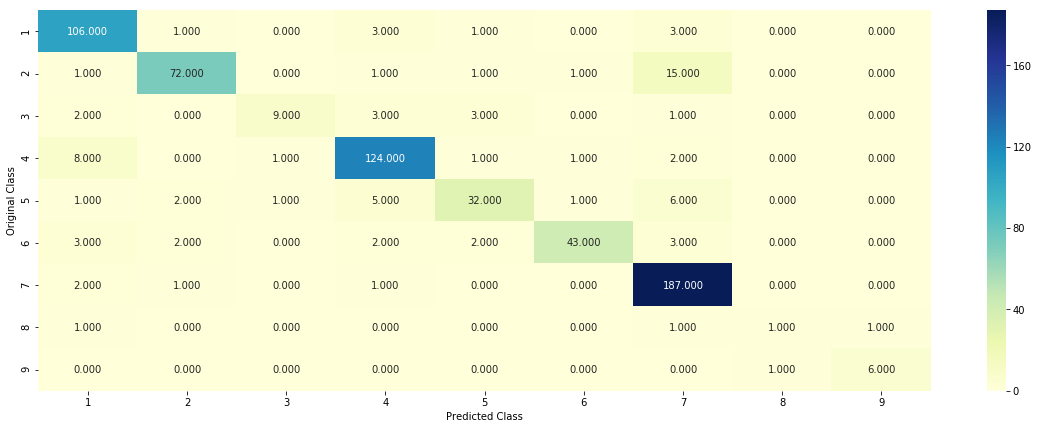

-------------------- Precision matrix (Columm Sum=1) --------------------


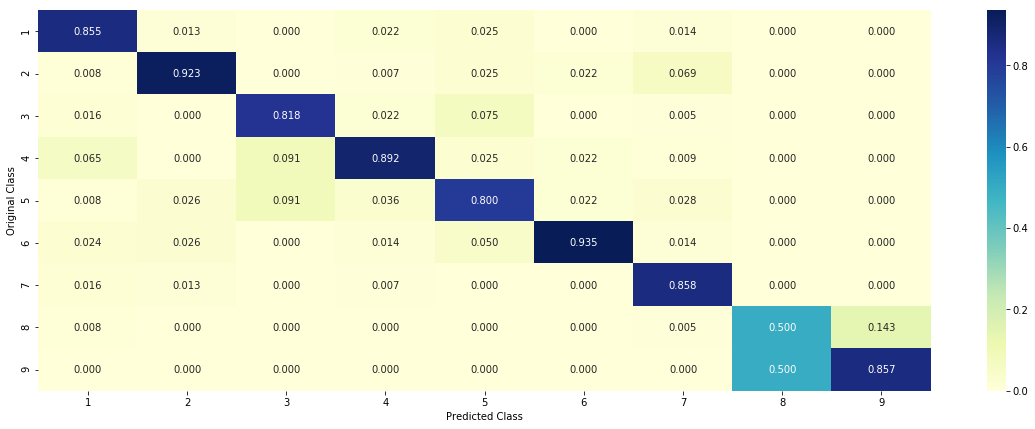

-------------------- Recall matrix (Row sum=1) --------------------


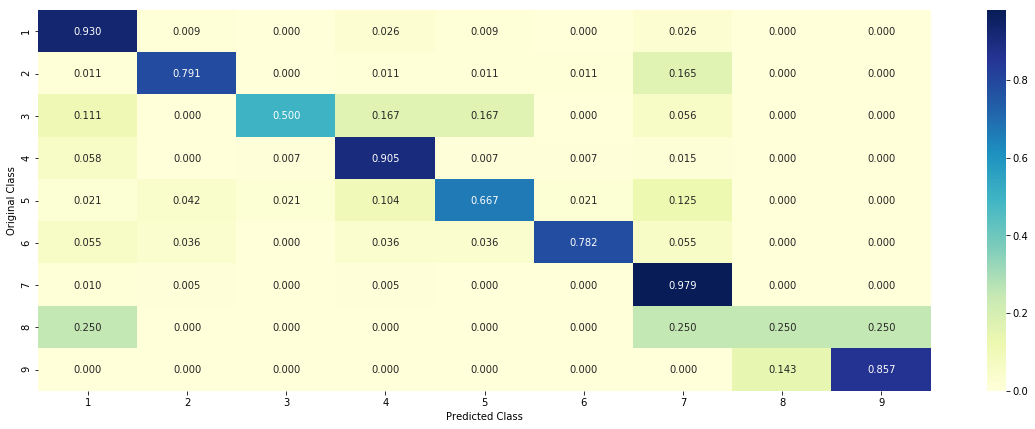

In [58]:
KNN_clf = KNeighborsClassifier(n_neighbors=5,weights='distance')
KNN_clf.fit(D_train_onehot_bow_fe, Y_train)
sig_clf1 = CalibratedClassifierCV(KNN_clf, method="sigmoid")
sig_clf1.fit(D_train_onehot_bow_fe, Y_train)
# ---------------------------------------------------------------------------------------------------------
LR_clf = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', n_jobs=-1)
LR_clf.fit(D_train_onehot_bow_fe, Y_train)
sig_clf2 = CalibratedClassifierCV(LR_clf, method="sigmoid")
sig_clf2.fit(D_train_onehot_bow_fe, Y_train)
# ---------------------------------------------------------------------------------------------------------
RF_clf = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=10, random_state=42, 
                             n_jobs=-1,class_weight = 'balanced')
RF_clf.fit(D_train_onehot_bow_fe, Y_train)
sig_clf3 = CalibratedClassifierCV(RF_clf, method="sigmoid")
sig_clf3.fit(D_train_onehot_bow_fe, Y_train)

vclf = VotingClassifier(estimators=[('KNN', sig_clf1), ('LR', sig_clf2), ('RF', sig_clf3)], voting='soft')
vclf.fit(D_train_onehot_bow_fe, Y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(Y_train, vclf.predict_proba(D_train_onehot_bow_fe)))
print("Log loss (CV) on the VotingClassifier :", log_loss(Y_cv, vclf.predict_proba(D_cv_onehot_bow_fe)))
print("Log loss (test) on the VotingClassifier :", log_loss(Y_test, vclf.predict_proba(D_test_onehot_bow_fe)))


# Miss classification rate on test data:
predicted_class = vclf.predict(D_test_onehot_bow_fe)
Miss_class_rate = 1 - accuracy_score(Y_test,predicted_class)
print('Number of missclassified points: ',round(Miss_class_rate*100,2),'%')

# Confusion matrix on test data:
plot_confusion_matrix(Y_test, predicted_class)

<h2>6 Model results </h2>

In [59]:
table = PrettyTable(["Model", "Featurerisation", "Train Log Loss", "CV Log Loss", "Test Log Loss", "Miss class %"])

In [60]:
table.add_row(['Random','no data used','2.48','2.50','2.52','91.28%'])
table.add_row(['Multinomial NB','onehot encoded bow','1.03','1.27','1.32','42.11%'])
table.add_row(['KNN','response encoded bow','0.95','1.26','1.23','43.01%'])
table.add_row(['KNN','response encoded tf-idf','1.22','1.98','2.00','78.50%'])
table.add_row(['LR(SGD)','onehot encoded bow','0.99','1.23','1.24','42.86%'])
table.add_row(['LR(SGD)','onehot encoded tf-idf','0.53','1.12','1.17','42.86%'])
table.add_row(['LR','onehot encoded bow','0.88','1.22','1.22','38.65%'])
table.add_row(['SVM(SGD)','onehot encoded bow','1.04','1.29','1.29','43.01%'])
table.add_row(['SVM(SGD)','onehot encoded tf-idf','0.54','1.16','1.23','44.66%'])
table.add_row(['RF','onehot encoded bow','0.82','1.18','1.15','35.04%'])
table.add_row(['RF','onehot encoded tf-idf','1.11','1.28','1.35','50.98%'])
table.add_row(['RF','response encoded bow','0.73','1.12','1.12','36.54%'])
table.add_row(['RF','response encoded tf-idf','1.32','1.58','1.63','64.81%'])
table.add_row(['Stacking Model (KNN,LR,RF)','onehot encoded bow','0.05','1.64','1.44','37.29%'])
table.add_row(['Stacking Model (KNN,LR,RF)','onehot encoded tf-idf','0.05','1.64','1.53','41.05%'])
table.add_row(['Stacking Model (KNN,LR,RF)','response encoded bow','0.07','1.49','1.39','36.84%'])
table.add_row(['Stacking Model (KNN,LR,RF)','response encoded tf-idf','0.27','3.04','2.88','70.68%'])
table.add_row(['Stacking Model (KNN,LR,RF)','onehot encoded bow','0.05','1.64','1.44','37.29%'])
table.add_row(['Stacking Model (KNN,LR,RF)','onehot encoded tf-idf','0.05','1.64','1.53','41.05%'])
table.add_row(['Stacking Model (KNN,LR,RF)','response encoded bow','0.07','1.49','1.39','36.84%'])
table.add_row(['Stacking Model (KNN,LR,RF)','response encoded tf-idf','0.27','3.04','2.88','70.68%'])
table.add_row(['Voting classifier (KNN,LR,RF)','onehot encoded bow','0.62','1.14','1.13','36.39%'])
table.add_row(['Voting classifier (KNN,LR,RF)','onehot encoded tf-idf','0.78','1.23','1.23','39.70%'])
table.add_row(['Voting classifier (KNN,LR,RF)','response encoded bow','0.57','1.09','1.10','35.19%'])
table.add_row(['Voting classifier (KNN,LR,RF)','response encoded tf-idf','0.89','1.70','1.65','67.07%'])
table.add_row(['Voting classifier (KNN,LR,RF)','onehot encoded bow + feature engineering','0.38','0.68','0.66','12.78%'])

In [61]:
print(table)

+-------------------------------+------------------------------------------+----------------+-------------+---------------+--------------+
|             Model             |             Featurerisation              | Train Log Loss | CV Log Loss | Test Log Loss | Miss class % |
+-------------------------------+------------------------------------------+----------------+-------------+---------------+--------------+
|             Random            |               no data used               |      2.48      |     2.50    |      2.52     |    91.28%    |
|         Multinomial NB        |            onehot encoded bow            |      1.03      |     1.27    |      1.32     |    42.11%    |
|              KNN              |           response encoded bow           |      0.95      |     1.26    |      1.23     |    43.01%    |
|              KNN              |         response encoded tf-idf          |      1.22      |     1.98    |      2.00     |    78.50%    |
|            LR(SGD)       

The voting classifier with KNN,LR and RF as base models trained on bow encoded text feature with bigrams and using jaccard_distance to look at the gene set coverage per class produced the best model with test log metric value of 0.66 and 12.78% miss classification rate